In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
import quandl
import scipy.optimize as sco
import scipy.interpolate as sci
import yfinance as yf
import math

plt.style.use(style ='seaborn')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Load data back

In [2]:
#Load data from saved file
IUS4_DE = pd.read_csv('IUS4_DE.csv', parse_dates =['Date'],index_col=['Date'])
DJSC_MI = pd.read_csv('DJSC_MI.csv', parse_dates =['Date'],index_col=['Date'])
BTC = pd.read_csv('BTC.csv', parse_dates =['Date'],index_col=['Date'])

In [3]:
# or we could load directly from yahoo finance
# IUS4_DE = yf.download("IUS4.DE", period='max')['Adj Close']
# DJSC_MI = yf.download("DJSC.MI", period='max')['Adj Close']
# BTC = yf.download("BTC-EUR", period='max')['Adj Close']

In [4]:
assets =['IUS4_DE', 'DJSC_MI', 'BTC']
data = pd.concat([IUS4_DE, DJSC_MI, BTC], axis=1).dropna() #axis=1 stack data horizontelly 
                                                                                     # dropna drop the rows with empty cells
data.columns = assets
data

,IUS4_DE,DJSC_MI,BTC
Date,,,
2019-09-18,35.215000,34.865002,9246.486328
2019-09-19,35.875000,35.060001,9292.973633
2019-09-20,36.044998,34.935001,9239.483398
2019-09-23,35.930000,34.564999,8850.279297
2019-09-24,36.055000,34.645000,7826.957031
...,...,...,...
2021-06-15,37.775002,47.365002,33325.593750
2021-06-16,38.005001,47.424999,31969.333984
2021-06-17,38.294998,46.605000,31943.062500


In [5]:
#undrop data for Visualization
#data_v = pd.concat([IUS4_DE, DJSC_MI, BTC], axis=1)
#data_v.columns = assets

# 1. ARIMA
ARIMA (Auto Regressive Integrated Moving Average) is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values.

ARIMA models explain a time series based on its own past values, basically its own lags and the lagged forecast errors.

An ARIMA model is characterized by 3 terms p, d, q:
- p is the order of the AR term
- d is the number of differencing required to make the time series stationary
- q is the order of the MA term

As we see in the parameters required by the model, any stationary time series can be modeled with ARIMA models.

Let's explain the term Auto Regressive in ARIMA. It means the model is a linear regression that uses its own lags as predictors. Linear regression models, as we know, work best when the predictors are independent of each other. Otherwise we run into multicollinearity issues where the regression becomes unstable due to correlation.

So in order to make ARIMA models work we need to difference it, in this case to compute the returns as they usually randomly distribute around a 0 mean.

p is the order of the Auto Regressive (AR) term. It refers to the number of lags to be used as predictors. 
q is the order of the Moving Average (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.



### 1.1. p, d, q

### 1.1.1 Stationarity

Substract the previous value from the current value. Now if we just difference once, we might not get a stationary series so we might need to do that multiple time. 

And the minimum number of differencing operations needed to make the series stationary needs to be imputed into our ARIMA model.

#### ADF test
We'll use the Augmented Dickey Fuller (ADF) test to check if the price series is stationary.

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then we can reject the null hypothesis and infer that the time series is indeed stationary.

So, in our case, if the p-value is greater than 0.05 we'll need to find the order of differencing.

So how to determine the right order of differencing?

The right order of differencing is the minimum differencing required to get a near-stationary series which roams around a defined mean and the Autocorrelation Function plot.

In [6]:
# Check if price series is stationary
from statsmodels.tsa.stattools import adfuller


In [7]:
for asset in data.columns:
    print(f"Test for: {asset}")
    result = adfuller(data[asset])
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print()
    

Test for: IUS4_DE
ADF Statistic: -1.850565402321801
p-value: 0.3556617641014323

Test for: DJSC_MI
ADF Statistic: -0.6329443323201521
p-value: 0.8633628673245353

Test for: BTC
ADF Statistic: -1.076713859443768
p-value: 0.7242682630117255



##### The p-values for all 3 assets are greater than 0.05 so we fail to reject the null hypothesis that the time series of those are non-stationary

### Autocorrelation Function (ACF)

In [8]:
from statsmodels.graphics.tsaplots import plot_acf

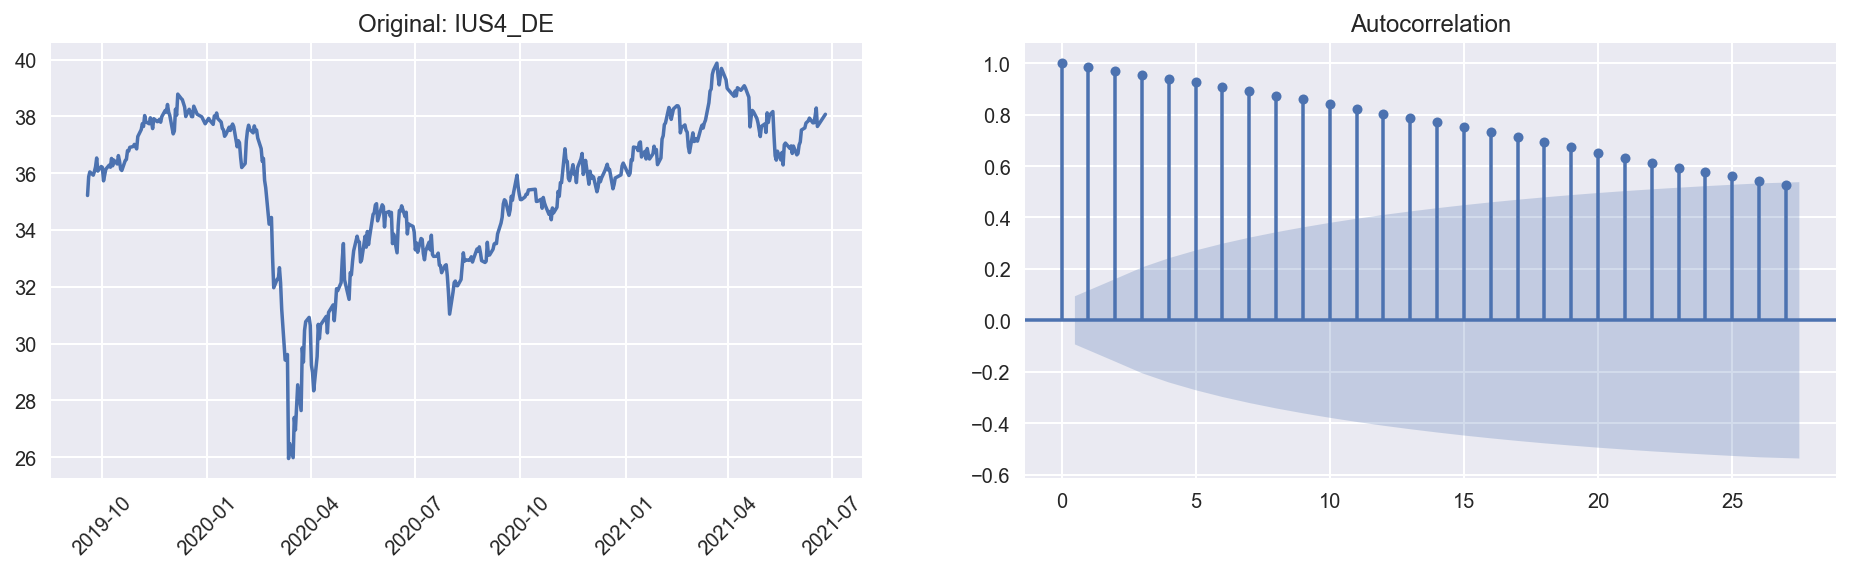

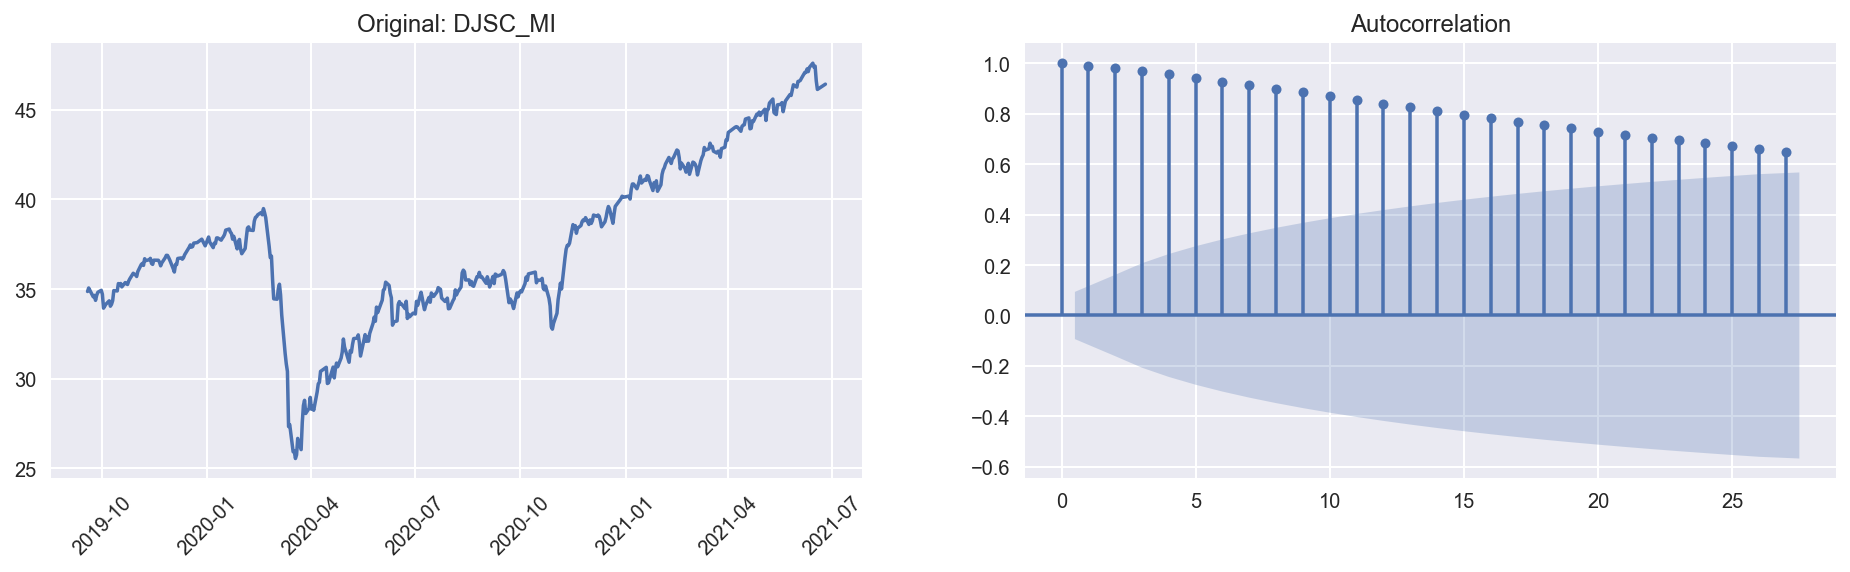

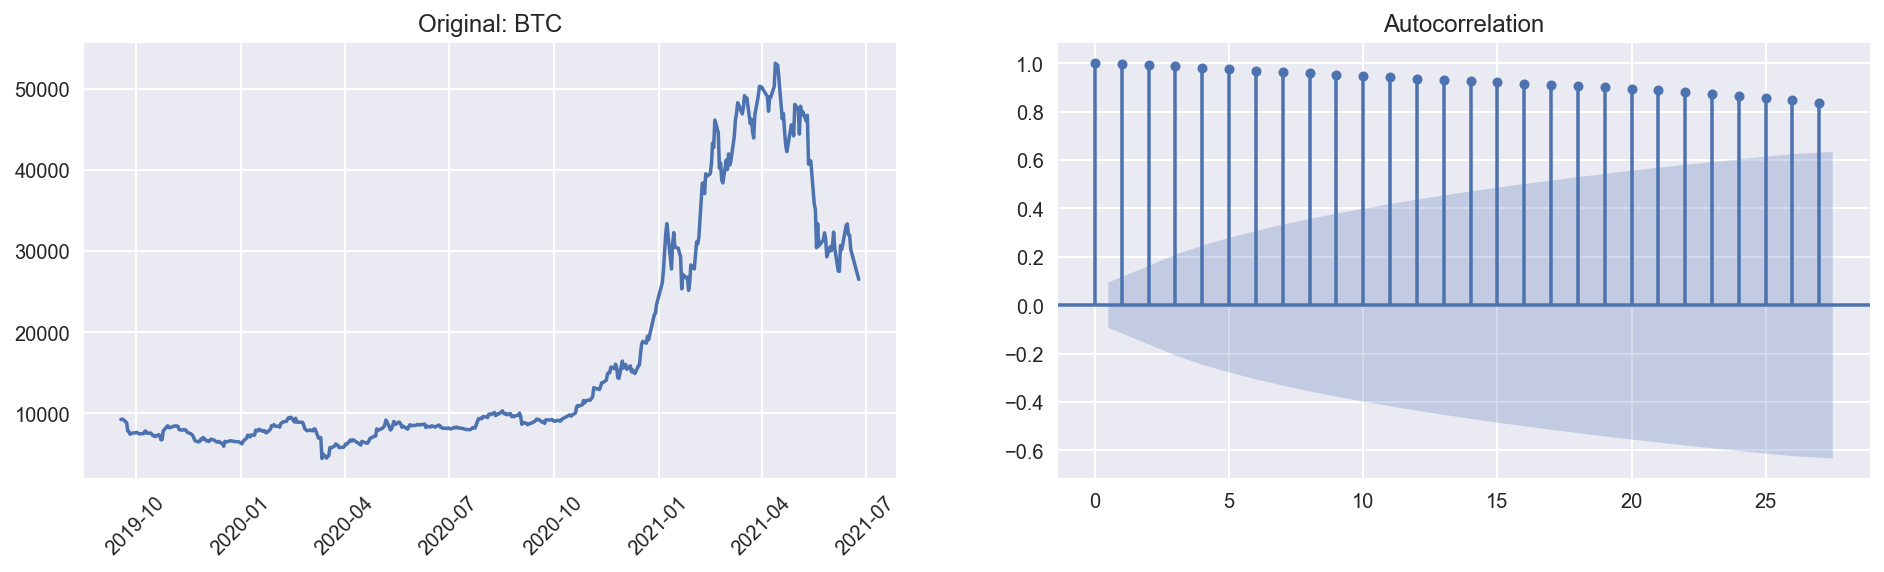

In [9]:
for asset in data.columns:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,4))
    plt.setp(ax1.get_xticklabels(), rotation=45)
    ax1.plot(data[asset].dropna())
    ax1.set_title(f"Original: {asset}")
    plot_acf(data[asset].dropna(), ax = ax2);
    plt.show()


### 1.1.2. Selecting d

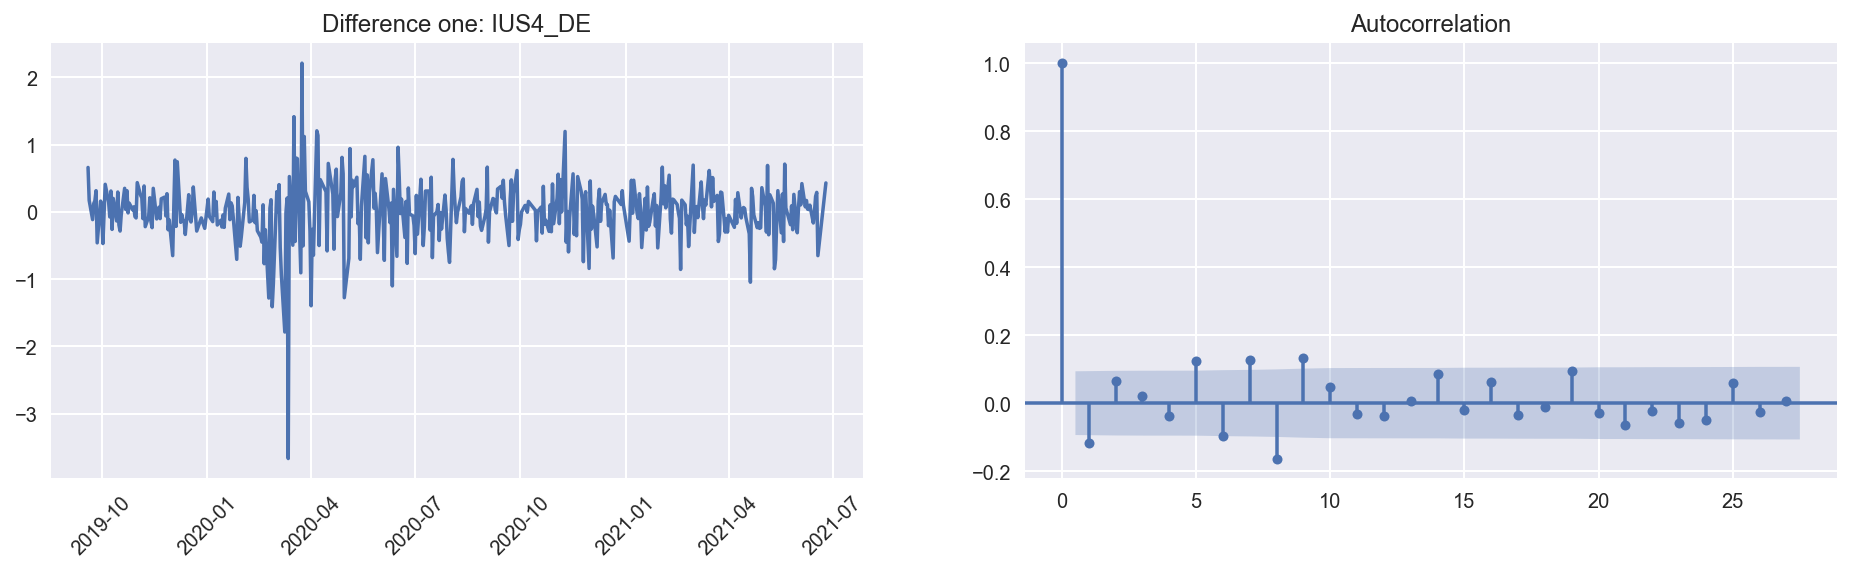

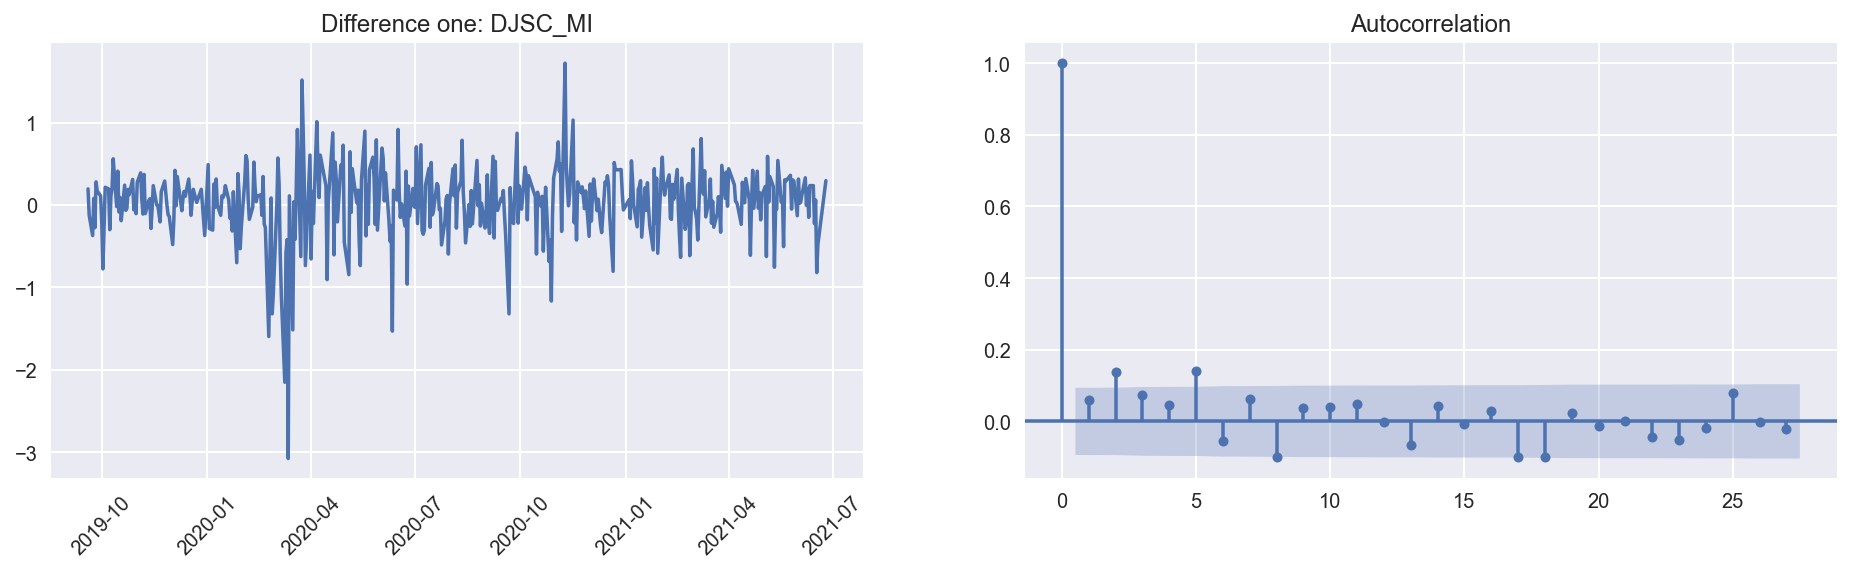

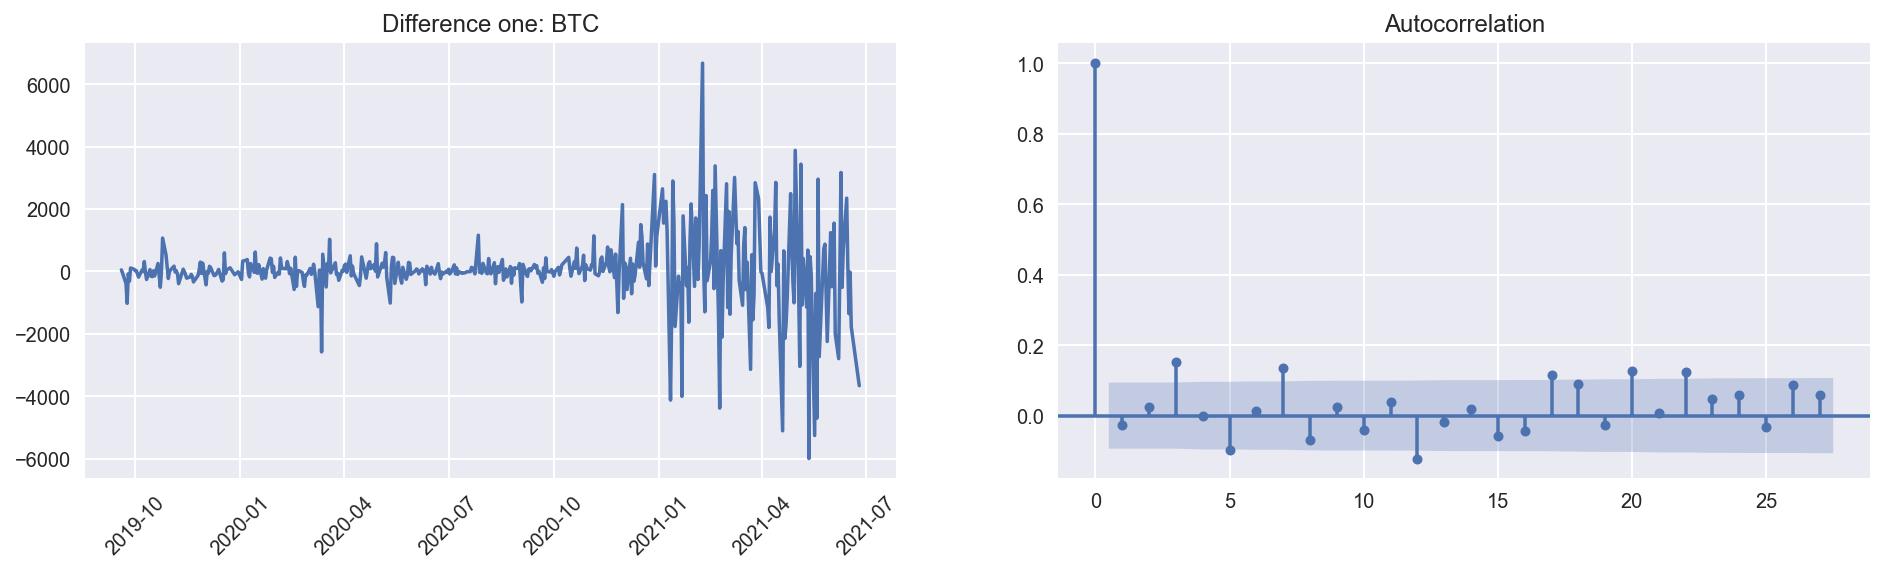

In [10]:
for asset in data.columns:

    diff = data[asset].diff().dropna()

    fig, (ax1, ax2) = plt.subplots( 1, 2, figsize=(16,4))
    plt.setp(ax1.get_xticklabels(), rotation=45)
    ax1.plot(diff)
    ax1.set_title(f"Difference one: {asset}")
    plot_acf(diff, ax=ax2);

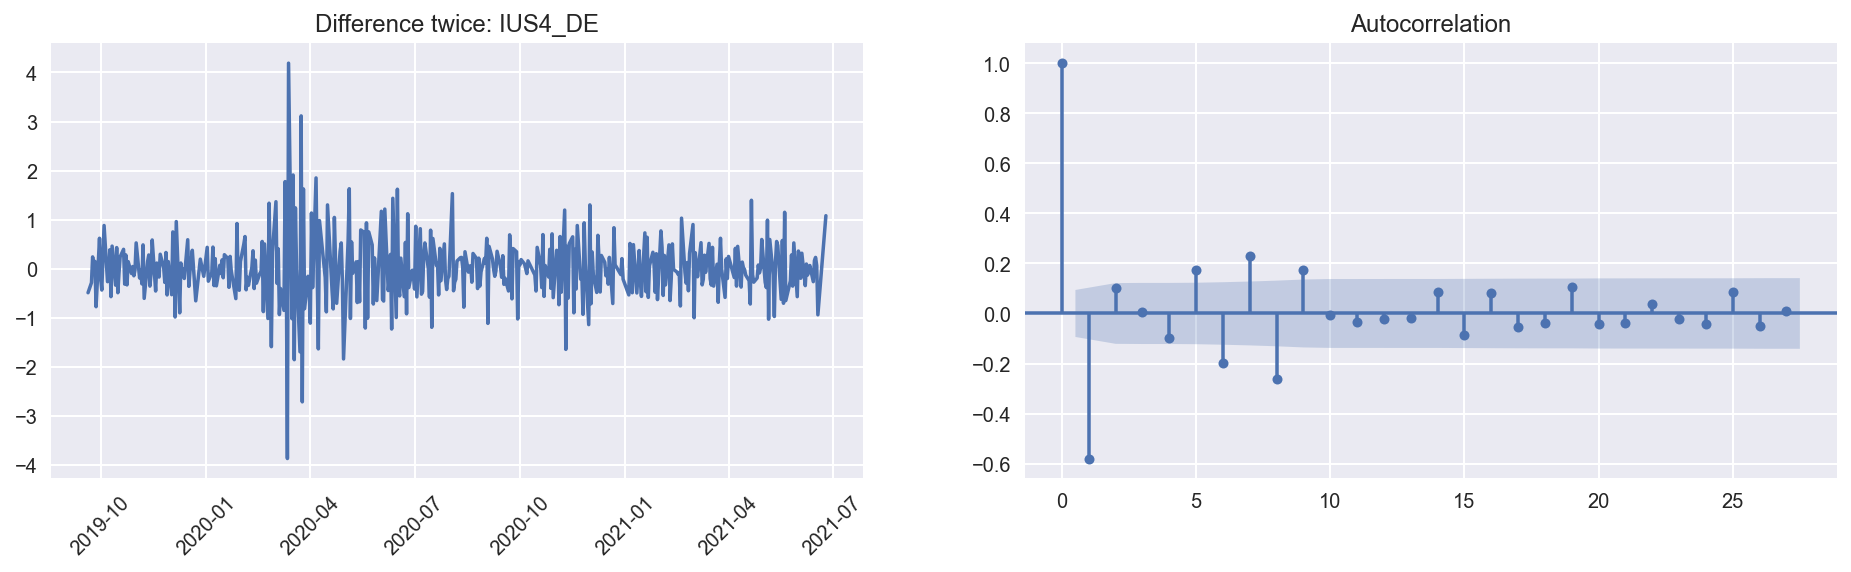

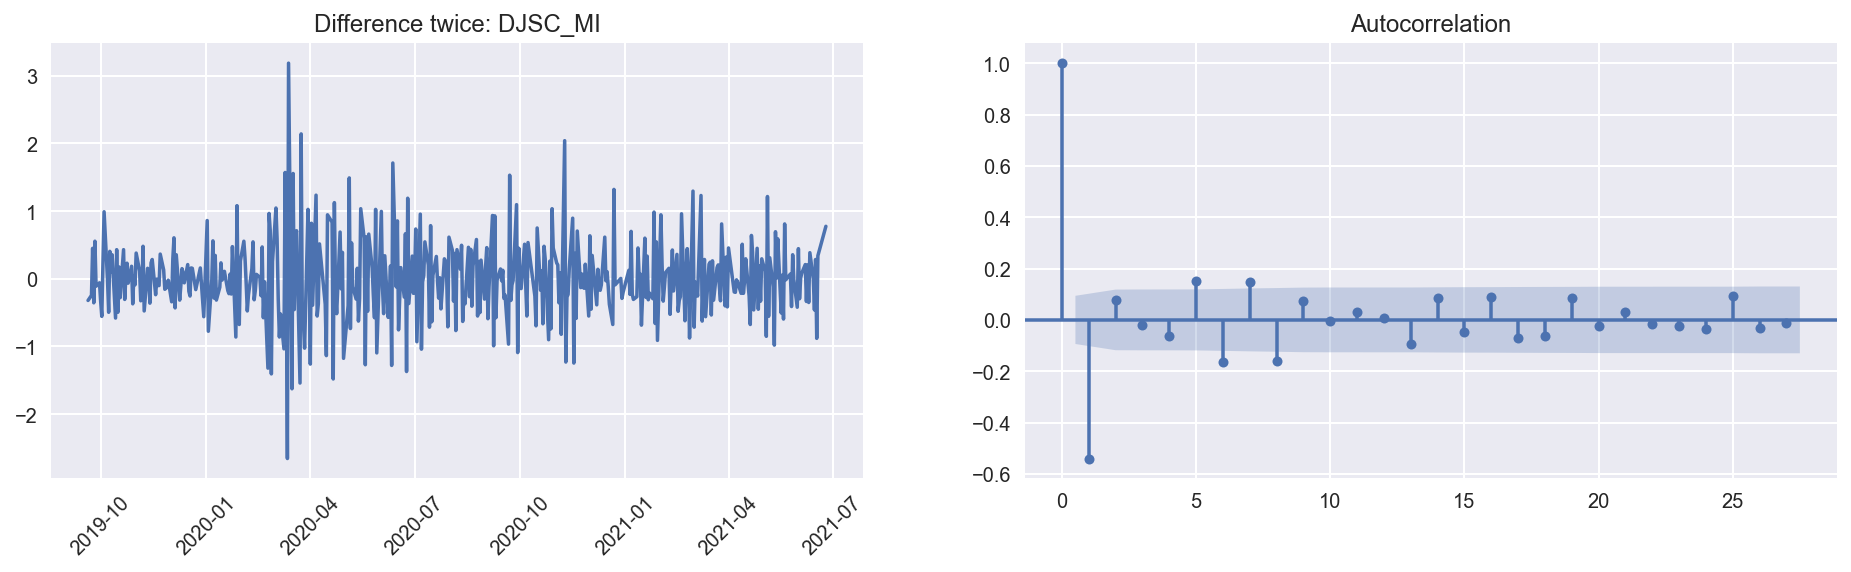

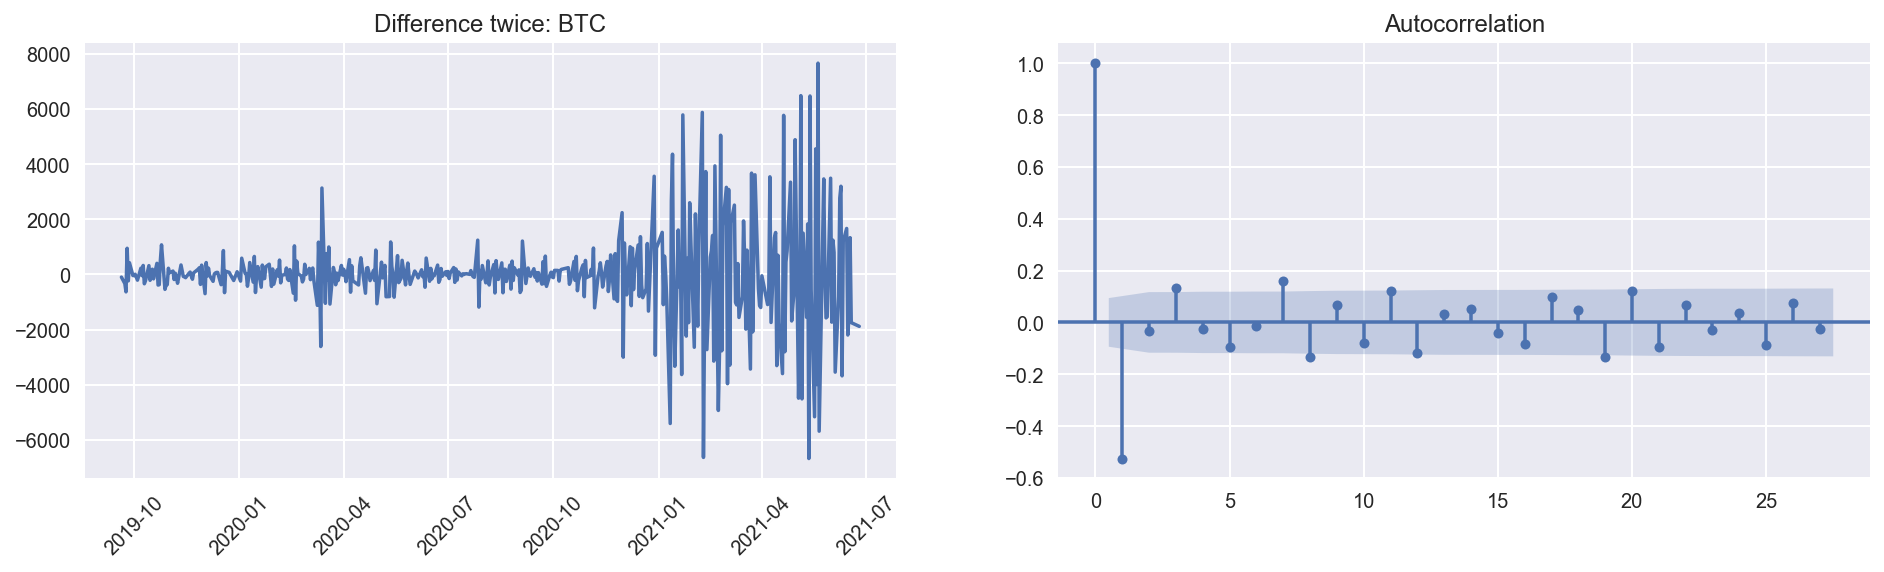

In [11]:
for asset in data.columns:

    diff = data[asset].diff().diff().dropna()

    fig, (ax1, ax2) = plt.subplots( 1, 2, figsize=(16,4))
    plt.setp(ax1.get_xticklabels(), rotation=45)
    ax1.plot(diff)
    ax1.set_title(f"Difference twice: {asset}")
    plot_acf(diff, ax=ax2);

###### There are not much differences in autocorrelation between "Difference one" and "Difference twice". So we the differencing value should be 1 for all assets. To confirm our selection, we use the pmdarima package to get the number of differencing.

In [12]:
from pmdarima.arima.utils import ndiffs

In [13]:
for asset in data.columns:
    n = ndiffs(data[asset], test= "adf")
    print(f"Optimal value for differencing of {asset}:", n)

Optimal value for differencing of IUS4_DE: 1
Optimal value for differencing of DJSC_MI: 1
Optimal value for differencing of BTC: 1


##### Therefore, we set d =1 for all 3 assets.

### 1.1.3. Selecting p
p is the order of the Auto Regressive term, It refers to the number of lags to be used as predictors.
We can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.
The partial autocorrelation represents the correlation between the series and its lags.

In [14]:
from statsmodels.graphics.tsaplots import plot_pacf

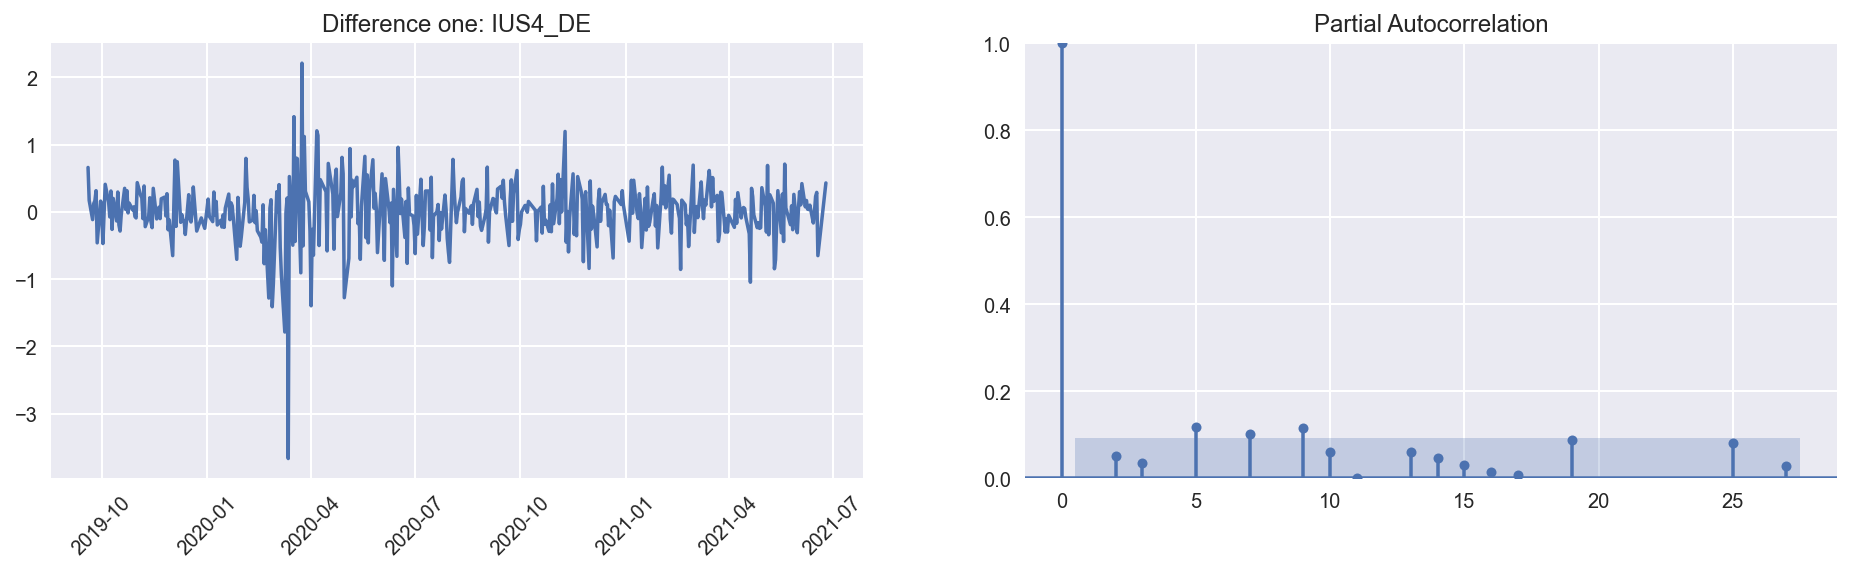

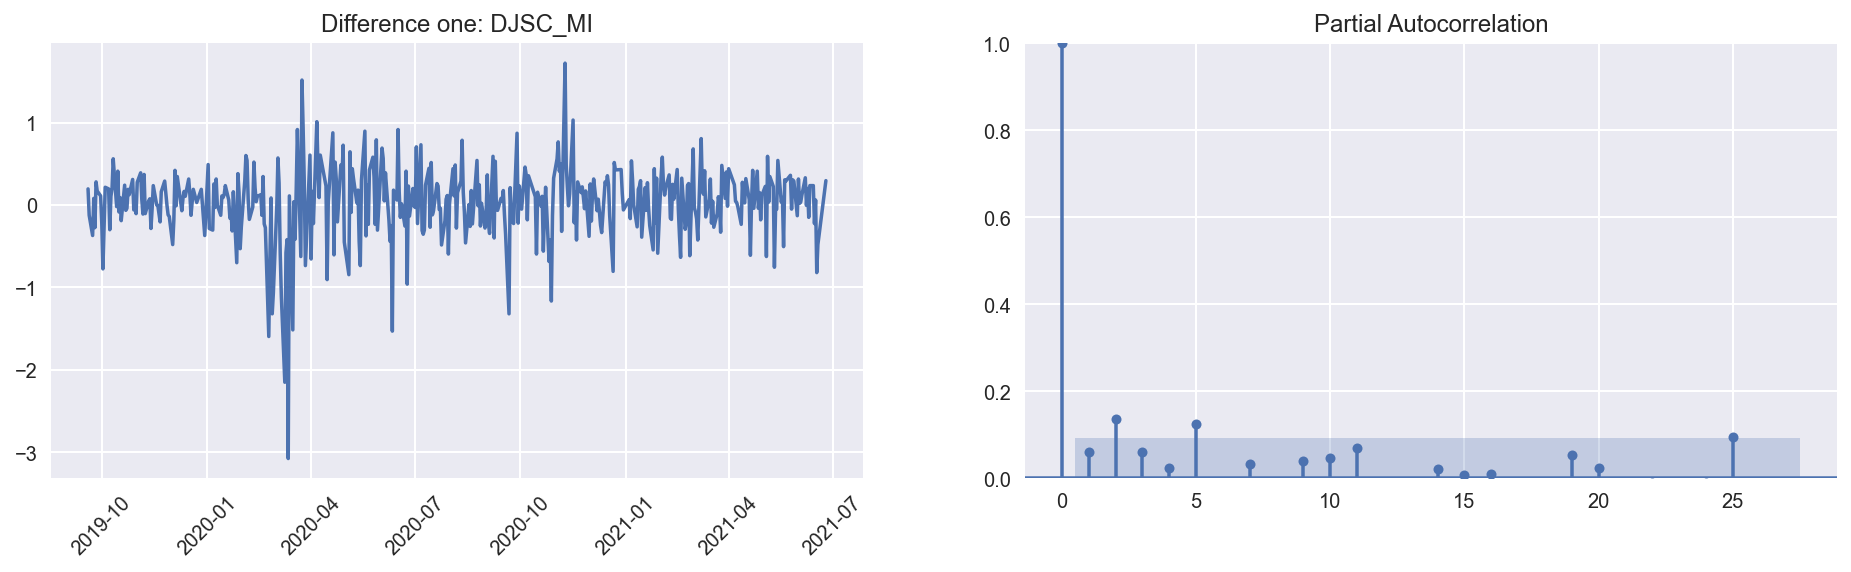

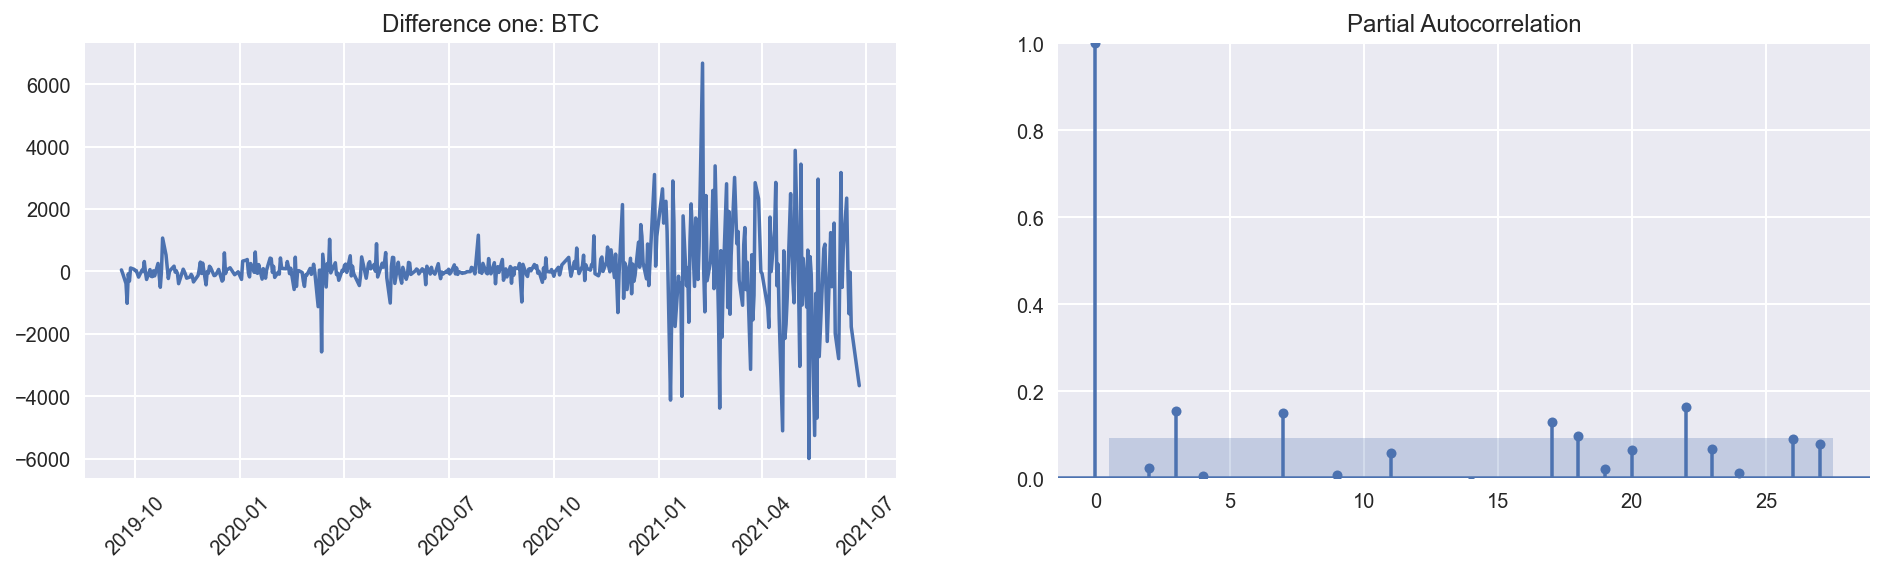

In [15]:
for asset in data.columns:

    diff = data[asset].diff().dropna()

    fig, (ax1, ax2) = plt.subplots( 1, 2, figsize=(16,4))
    plt.setp(ax1.get_xticklabels(), rotation=45)
    ax1.plot(diff)
    ax1.set_title(f"Difference one: {asset}")
    ax2.set_ylim(0,1)
    plot_pacf(diff, ax=ax2);

###### We can observe that the PACF lag for IUS4_DE = 4,  DJSC_MI = 7,  BTC = 3 are significant as they're above the significance lines.

#### q
q is the order of the Moving Average term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.
We can look at the ACF plot for the number of MA terms.

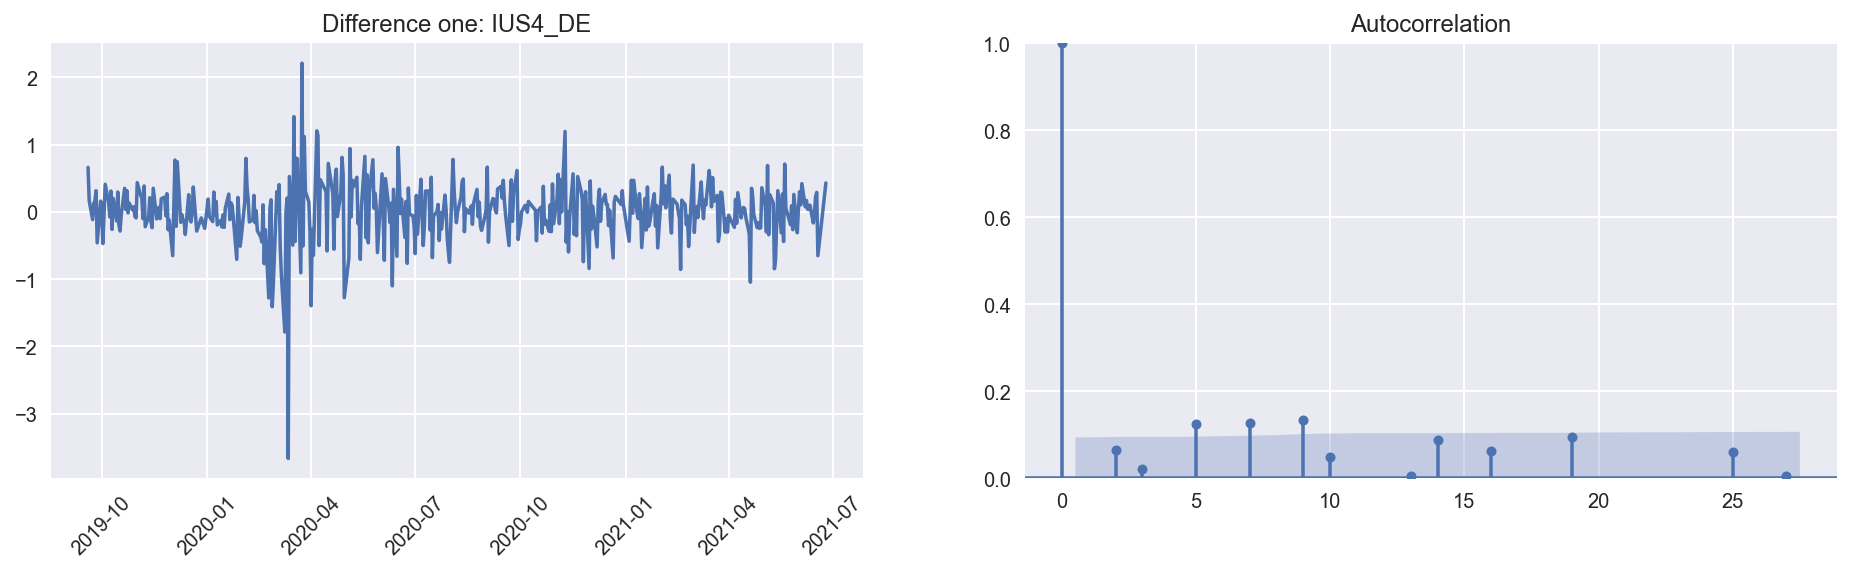

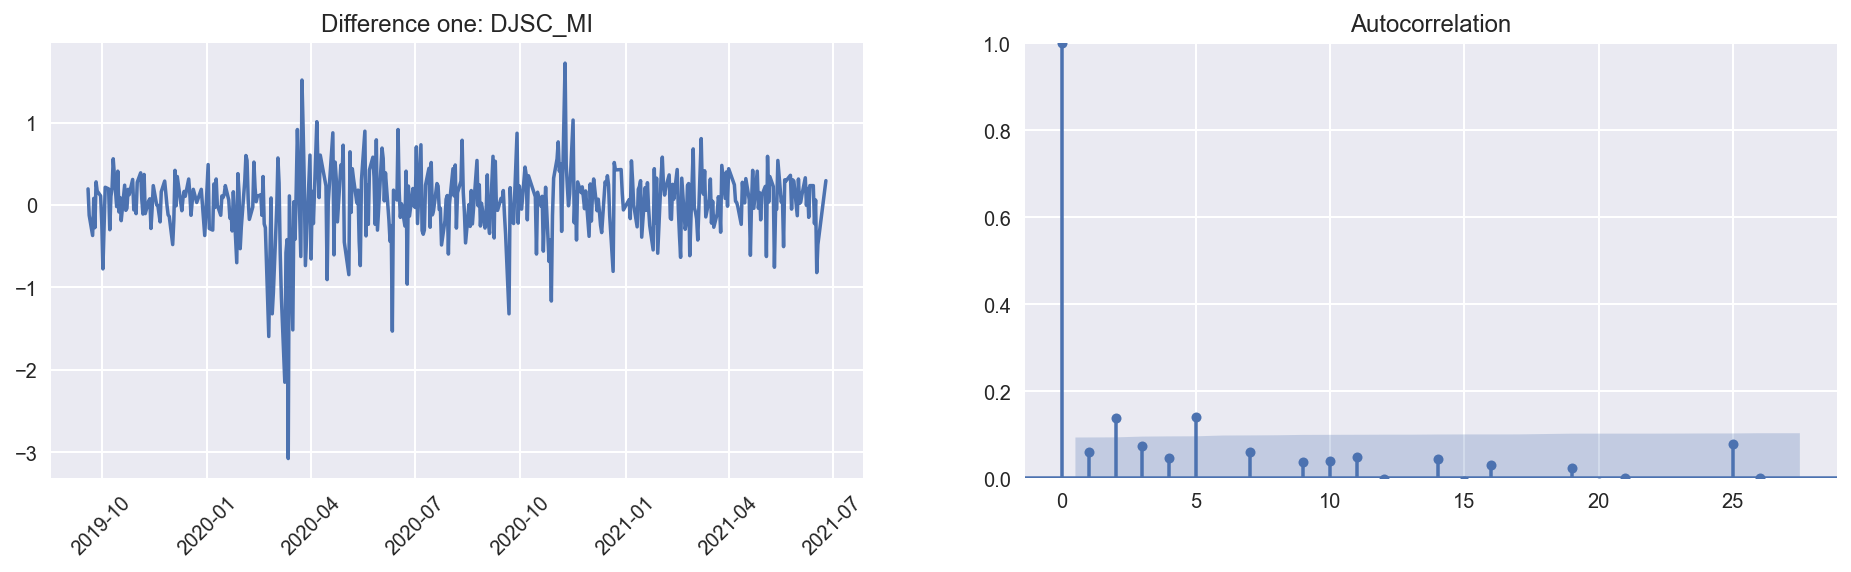

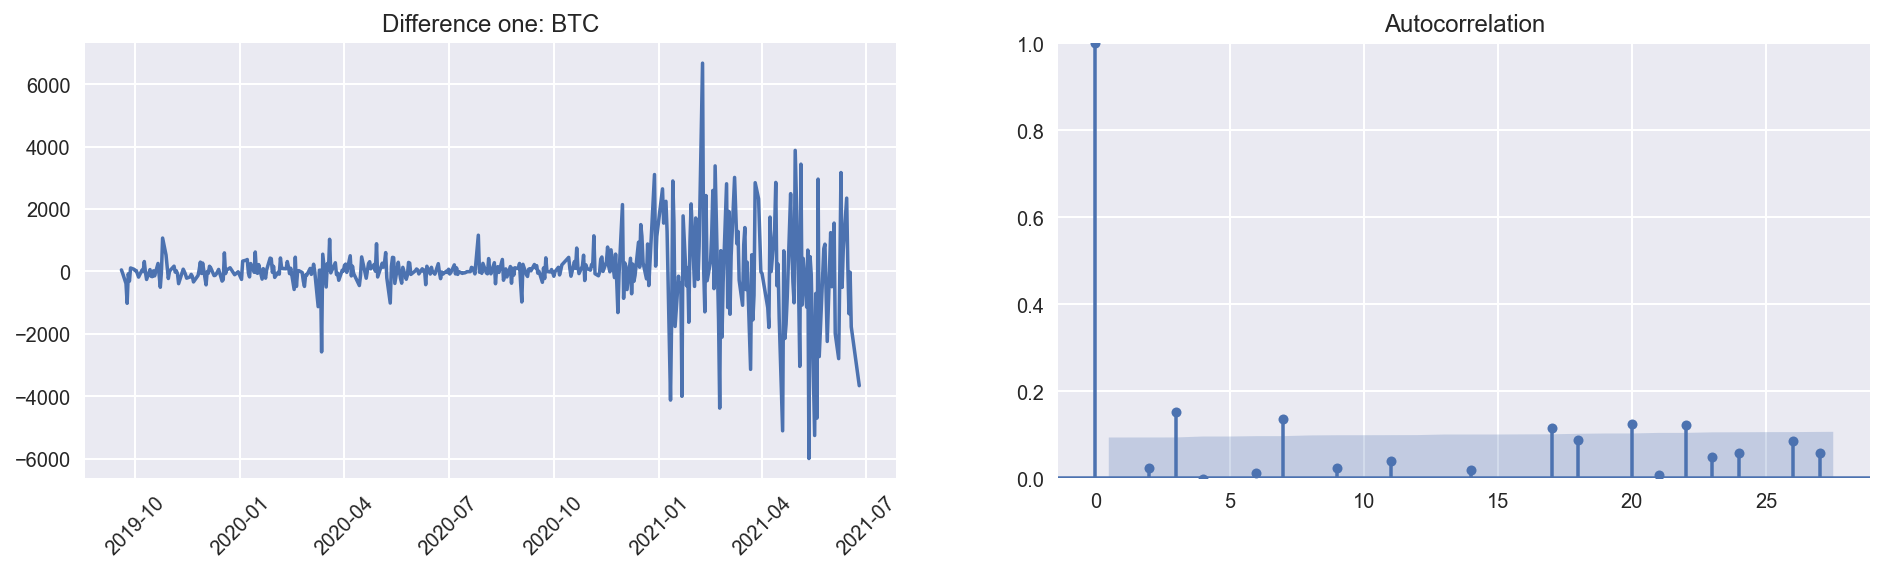

In [16]:
for asset in data.columns:

    diff = data[asset].diff().dropna()

    fig, (ax1, ax2) = plt.subplots( 1, 2, figsize=(16,4))
    plt.setp(ax1.get_xticklabels(), rotation=45)
    ax1.plot(diff)
    ax1.set_title(f"Difference one: {asset}")
    ax2.set_ylim(0,1)
    plot_acf(diff, ax=ax2);

### 1.2. Using Auto ARIMA

In [17]:
from pmdarima.arima import auto_arima
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [18]:
# Split data for training
def train_test_split(data, prediction_day):
    data = data.dropna()
    n= len(data) - prediction_day
    train = pd.DataFrame(data[:n])
    test = pd.DataFrame(data[n:])
    return train, test

### Prediction model for IUS4_DE

In [21]:
train, test = train_test_split(data["IUS4_DE"], 30)

In [22]:
arima_model = auto_arima(train,start_p=0, d=1, start_q=0, 
                          max_p=10, max_d=5, max_q=10, start_P=0, 
                          D=1, start_Q=0, max_P=10, max_D=5,
                          max_Q=10, m=5, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=750.003, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=655.427, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=538.801, Time=0.13 sec
 ARIMA(0,1,1)(0,1,0)[5]             : AIC=750.563, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[5]             : AIC=inf, Time=0.19 sec
 ARIMA(0,1,1)(0,1,2)[5]             : AIC=inf, Time=0.30 sec
 ARIMA(0,1,1)(1,1,0)[5]             : AIC=656.518, Time=0.08 sec
 ARIMA(0,1,1)(1,1,2)[5]             : AIC=540.332, Time=0.54 sec
 ARIMA(0,1,0)(0,1,1)[5]             : AIC=540.869, Time=0.08 sec
 ARIMA(1,1,1)(0,1,1)[5]             : AIC=539.486, Time=0.21 sec
 ARIMA(0,1,2)(0,1,1)[5]             : AIC=538.254, Time=0.17 sec
 ARIMA(0,1,2)(0,1,0)[5]             : AIC=752.545, Time=0.04 sec
 ARIMA(0,1,2)(1,1,1)[5]             : AIC=inf, Time=0.20 sec
 ARIMA(0,1,2)(0,1,2)[5]             : AIC=inf, Time=0.30 sec
 ARIMA(0,1,2)(1,1,0)[5]             : AIC=652.832, Time=0.07 se

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  408
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 5)   Log Likelihood                -265.127
Date:                             Tue, 29 Jun 2021   AIC                            538.254
Time:                                     13:44:23   BIC                            554.240
Sample:                                          0   HQIC                           544.583
                                             - 408                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1044      0.042     -2.468      0.014      -0.187      -0.021
ma.L2          0.0798      0.043      1.868      0.062      -0.004       0.164
ma.S.L5       -0.9461      0.020    -47.919      0.000      -0.985      -0.907
sigma2         0.2129      0.007     30.408      0.000       0.199       0.227
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1153.94
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.37   Skew:                            -0.91
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

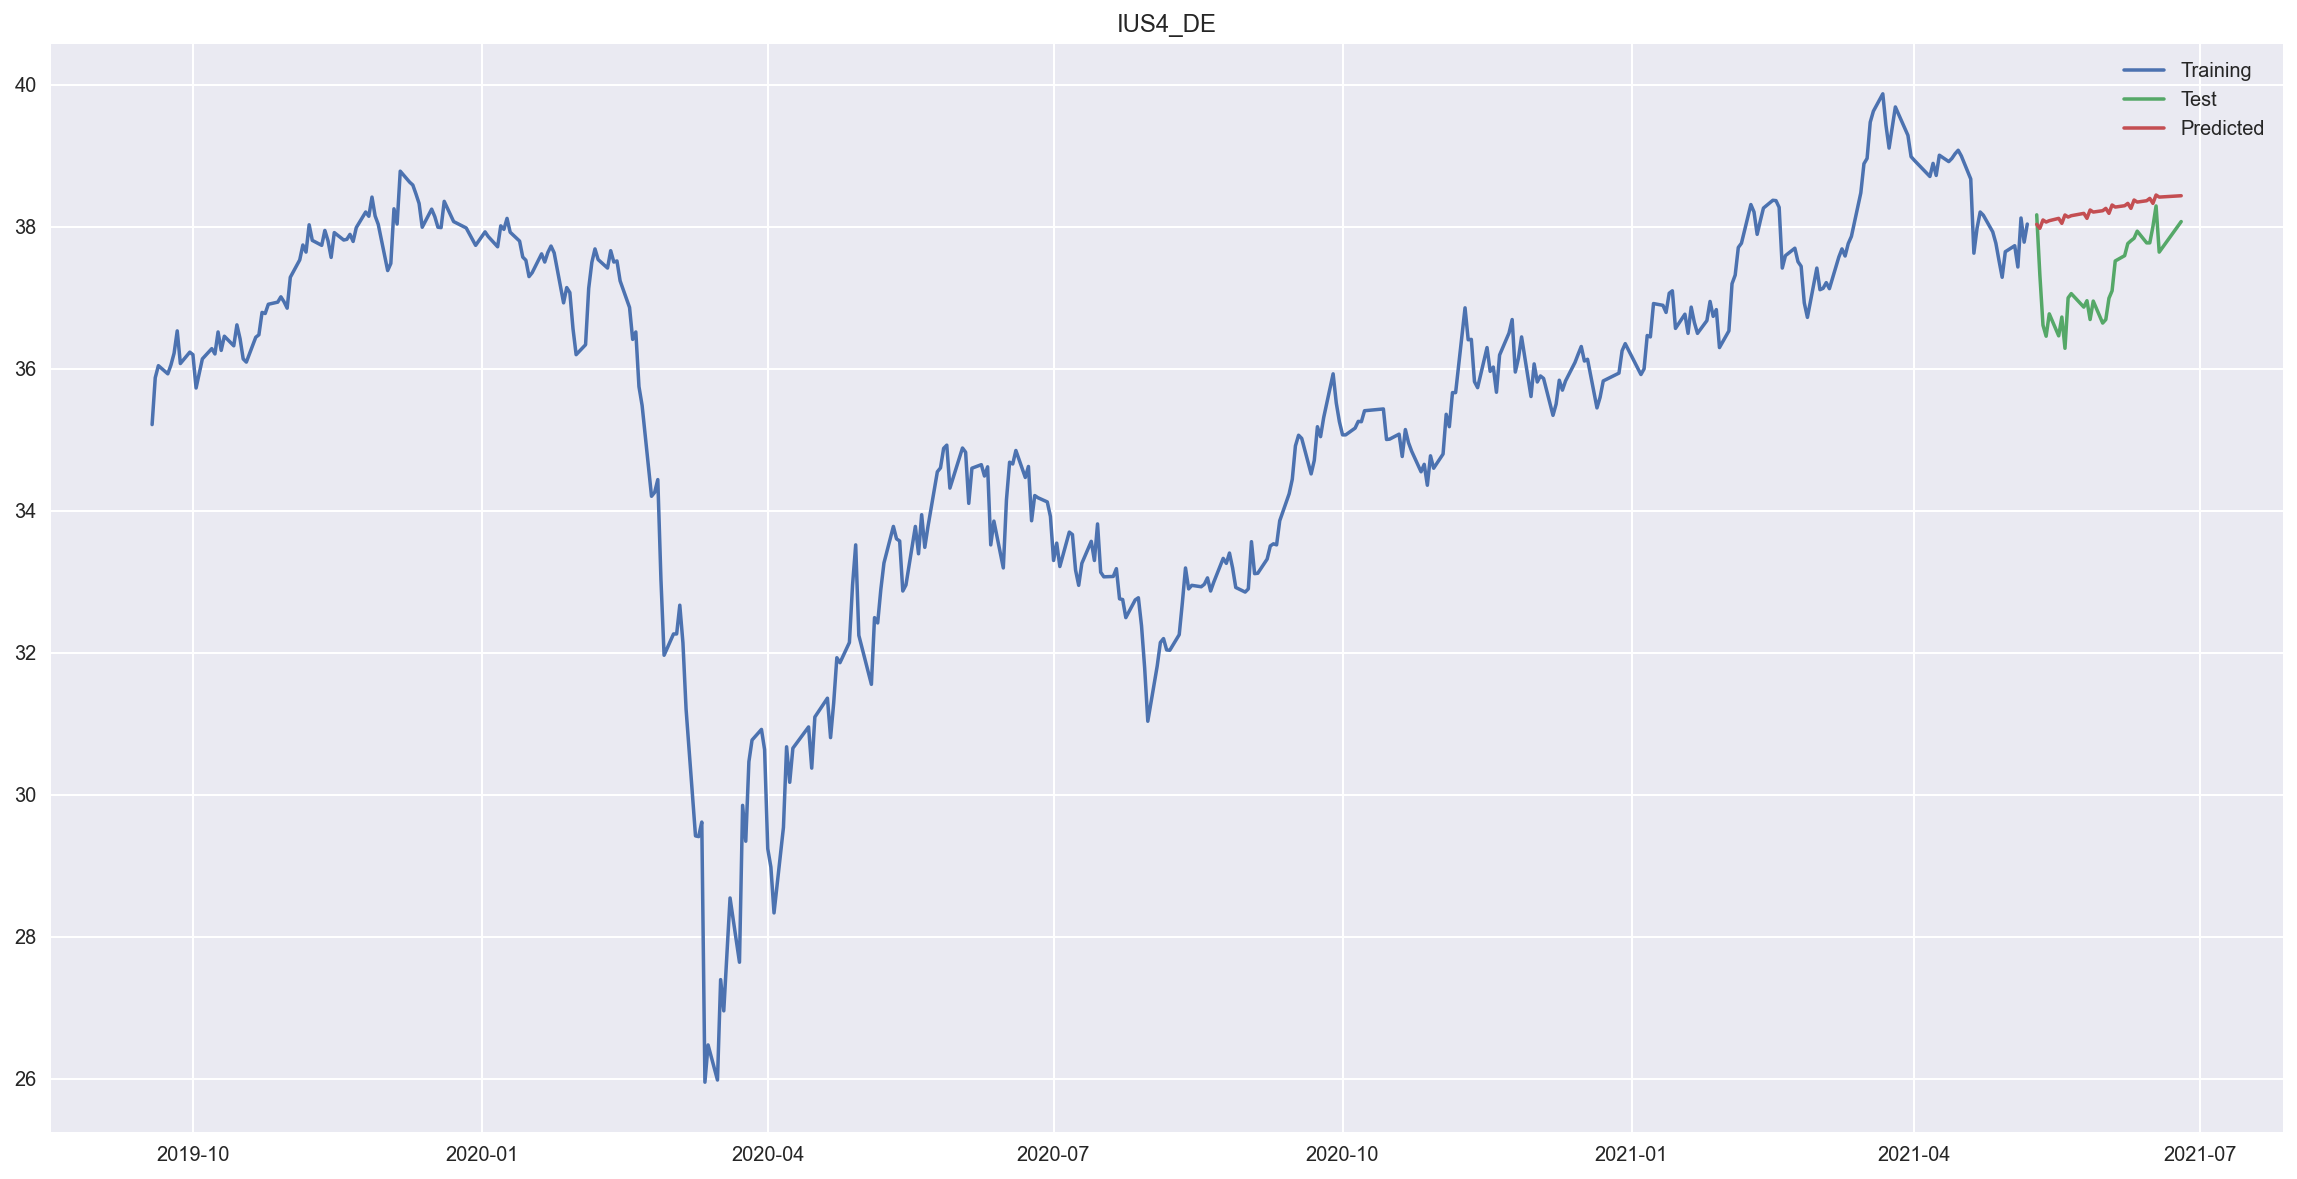

In [23]:
prediction = pd.DataFrame(arima_model.predict(n_periods = len(test)), index = test.index)
prediction.columns = ['Predicted_IUS4_DE']

plt.figure(figsize=(20,10))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction,label="Predicted")
plt.title(label ="IUS4_DE")
plt.legend(loc = 'best')
plt.show()

In [24]:
test['Predicted_IUS4_DE'] = prediction
r2_score_1 = r2_score(test['IUS4_DE'], test['Predicted_IUS4_DE'])
print(r2_score_1)
math.sqrt(mean_squared_error(test['IUS4_DE'],test['Predicted_IUS4_DE']))


-2.5909949398613574


1.09584472326956

### Prediction model for DJSC_MI

In [25]:
train, test = train_test_split(data["DJSC_MI"], prediction_day= 30)

In [26]:
arima_model = auto_arima(train,start_p=0, d=1, start_q=0, 
                          max_p=10, max_d=5, max_q=10, start_P=0, 
                          D=1, start_Q=0, max_P=10, max_D=5,
                          max_Q=10, m=5, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=724.999, Time=0.12 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=639.543, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=524.731, Time=0.15 sec
 ARIMA(0,1,1)(0,1,0)[5]             : AIC=724.738, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[5]             : AIC=inf, Time=0.26 sec
 ARIMA(0,1,1)(0,1,2)[5]             : AIC=inf, Time=0.29 sec
 ARIMA(0,1,1)(1,1,0)[5]             : AIC=639.737, Time=0.06 sec
 ARIMA(0,1,1)(1,1,2)[5]             : AIC=523.818, Time=0.44 sec
 ARIMA(0,1,1)(2,1,2)[5]             : AIC=inf, Time=0.91 sec
 ARIMA(0,1,1)(1,1,3)[5]             : AIC=inf, Time=1.31 sec
 ARIMA(0,1,1)(0,1,3)[5]             : AIC=inf, Time=0.48 sec
 ARIMA(0,1,1)(2,1,1)[5]             : AIC=inf, Time=0.26 sec
 ARIMA(0,1,1)(2,1,3)[5]             : AIC=inf, Time=1.22 sec
 ARIMA(0,1,0)(1,1,2)[5]             : AIC=inf, Time=0.29 sec
 ARIMA(1,1,1)(1,1,2)[5]             : AIC=518.016, Time=0.81 sec
 ARIMA(1,1,1)(

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  408
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 5)   Log Likelihood                -252.784
Date:                             Tue, 29 Jun 2021   AIC                            515.567
Time:                                     13:45:05   BIC                            535.550
Sample:                                          0   HQIC                           523.479
                                             - 408                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6472      0.142      4.567      0.000       0.369       0.925
ma.L1         -0.6049      0.141     -4.290      0.000      -0.881      -0.329
ma.L2          0.1171      0.046      2.537      0.011       0.027       0.208
ma.S.L5       -0.9349      0.021    -44.530      0.000      -0.976      -0.894
sigma2         0.2008      0.010     19.827      0.000       0.181       0.221
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               310.36
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                            -0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

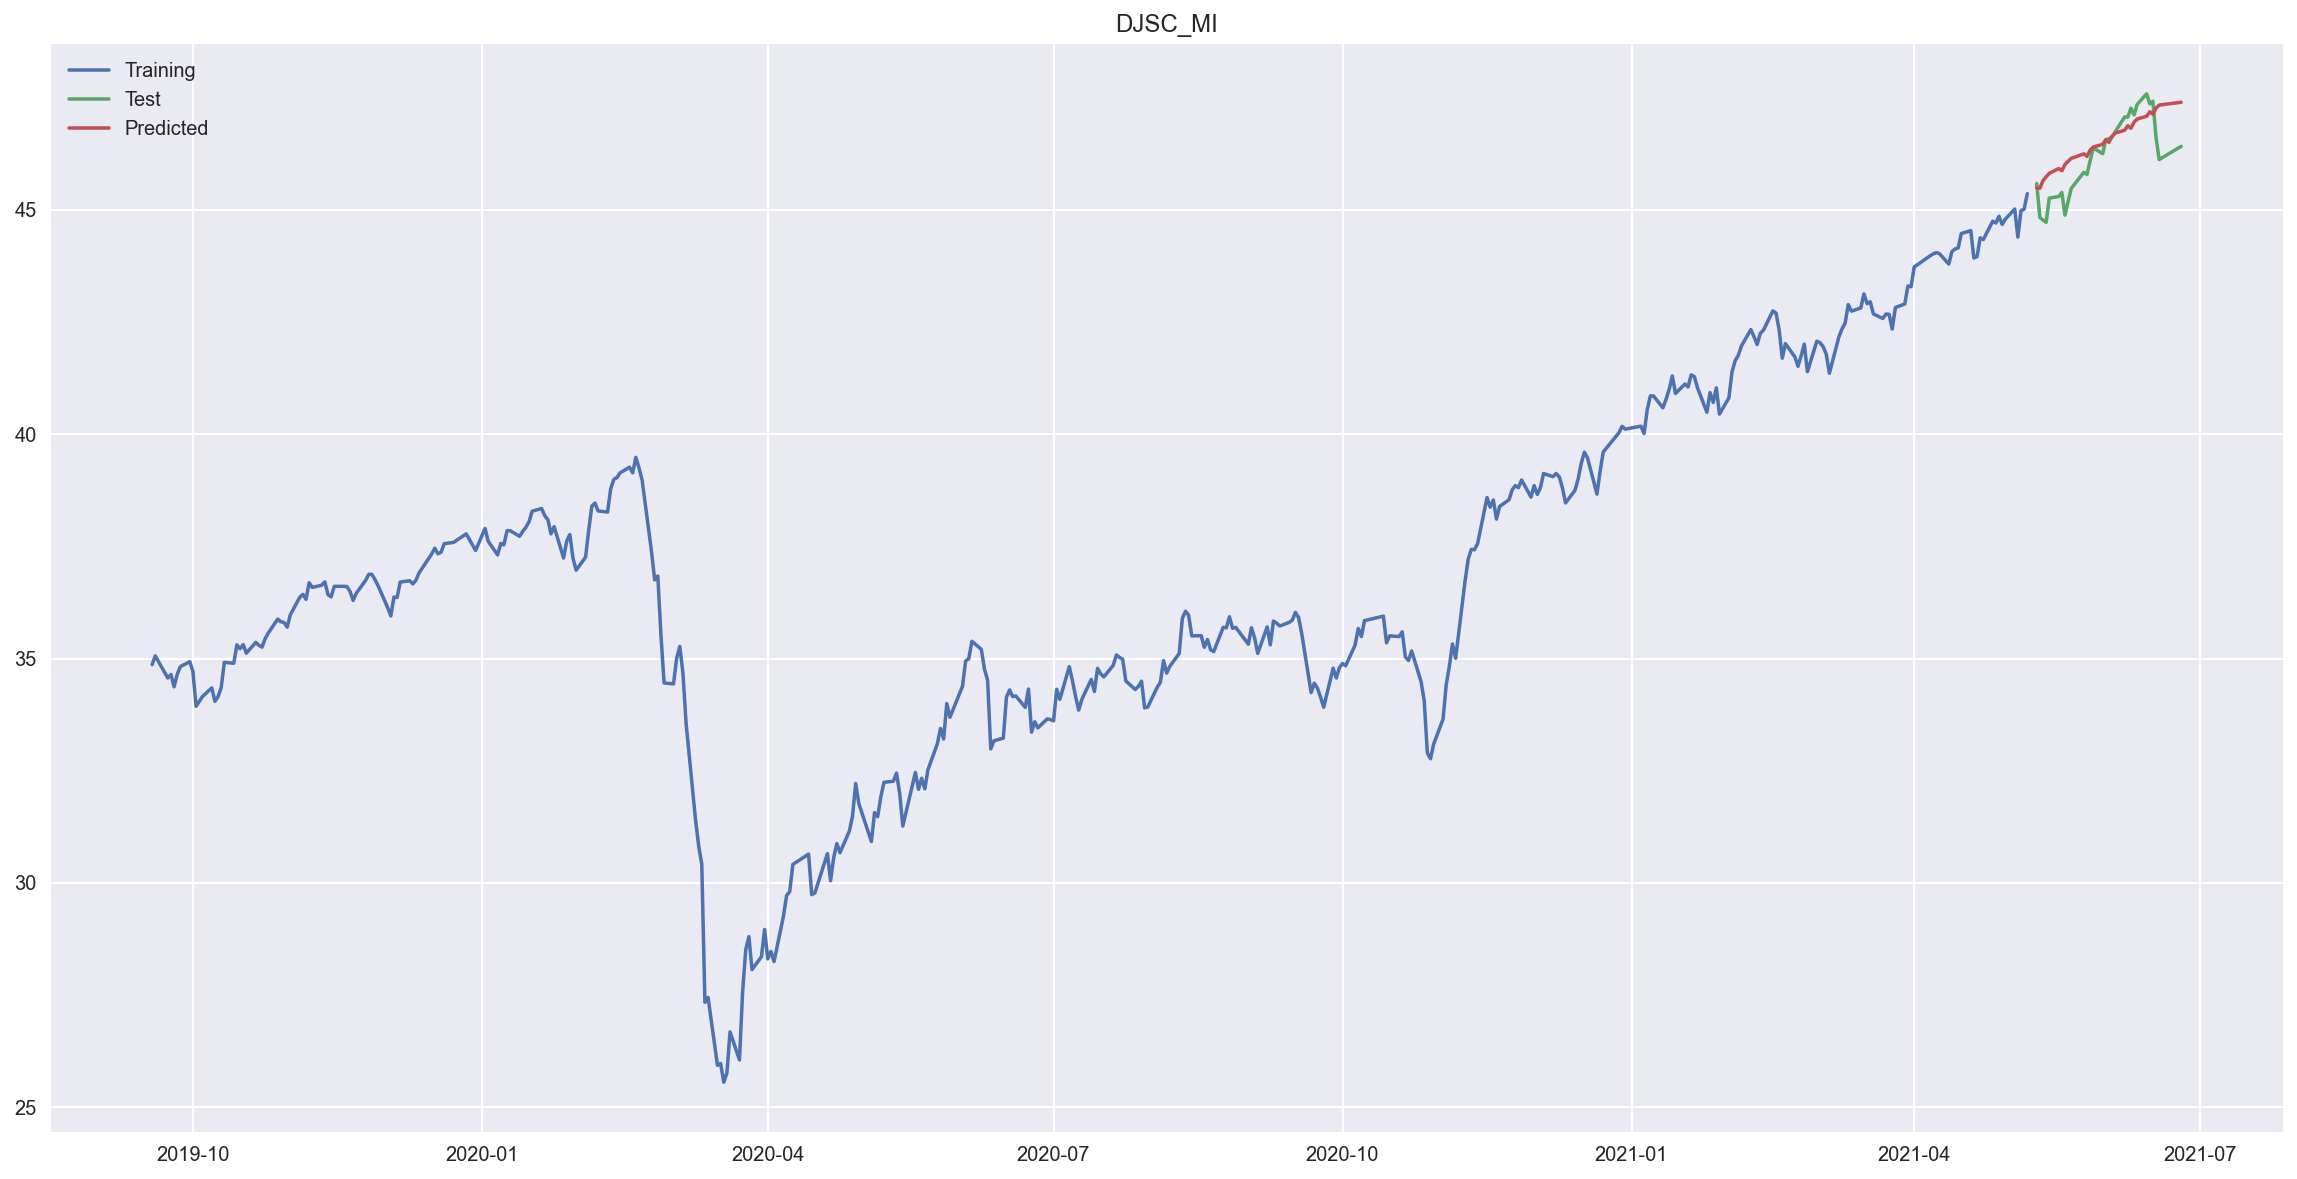

In [27]:
prediction = pd.DataFrame(arima_model.predict(n_periods = len(test)), index = test.index)
prediction.columns = ['Predicted_DJSC_MI']

plt.figure(figsize=(20,10))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction,label="Predicted")
plt.title(label ="DJSC_MI")
plt.legend(loc = 'best')
plt.show()

In [28]:
test['Predicted_DJSC_MI'] = prediction
r2_score_2 = r2_score(test['DJSC_MI'], test['Predicted_DJSC_MI'])
print(r2_score_2)
math.sqrt(mean_squared_error(test['DJSC_MI'],test['Predicted_DJSC_MI']))

0.5725038156579396


0.5726914218976017

### Prediction model for BTC

In [29]:
train, test = train_test_split(data["BTC"], prediction_day= 30)

In [30]:
arima_model = auto_arima(train,start_p=0, d=1, start_q=0, 
                          max_p=10, max_d=5, max_q=10, start_P=0, 
                          D=1, start_Q=0, max_P=10, max_D=5,
                          max_Q=10, m=5, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=7003.856, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=6889.892, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=inf, Time=0.22 sec
 ARIMA(1,1,0)(0,1,0)[5]             : AIC=7005.031, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[5]             : AIC=6838.246, Time=0.30 sec
 ARIMA(1,1,0)(3,1,0)[5]             : AIC=6805.690, Time=0.50 sec
 ARIMA(1,1,0)(4,1,0)[5]             : AIC=6791.746, Time=0.82 sec
 ARIMA(1,1,0)(5,1,0)[5]             : AIC=6783.348, Time=1.64 sec
 ARIMA(1,1,0)(6,1,0)[5]             : AIC=6772.062, Time=2.05 sec
 ARIMA(1,1,0)(7,1,0)[5]             : AIC=6758.992, Time=2.69 sec
 ARIMA(1,1,0)(8,1,0)[5]             : AIC=6744.610, Time=4.50 sec
 ARIMA(1,1,0)(9,1,0)[5]             : AIC=6740.922, Time=5.12 sec
 ARIMA(1,1,0)(10,1,0)[5]             : AIC=6742.373, Time=7.14 sec
 ARIMA(1,1,0)(9,1,1)[5]             : AIC=inf, Time=13.50 sec
 ARIMA(1,1,0)(8,1,1)[5]             : AIC

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  408
Model:             SARIMAX(0, 1, 0)x(6, 1, [1], 5)   Log Likelihood               -3353.298
Date:                             Tue, 29 Jun 2021   AIC                           6722.596
Time:                                     13:47:37   BIC                           6754.568
Sample:                                          0   HQIC                          6735.255
                                             - 408                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L5       -0.1741      0.038     -4.604      0.000      -0.248      -0.100
ar.S.L10      -0.1785      0.037     -4.813      0.000      -0.251      -0.106
ar.S.L15      -0.1460      0.037     -3.911      0.000      -0.219      -0.073
ar.S.L20      -0.0907      0.032     -2.843      0.004      -0.153      -0.028
ar.S.L25      -0.1138      0.039     -2.921      0.003      -0.190      -0.037
ar.S.L30      -0.1017      0.036     -2.847      0.004      -0.172      -0.032
ma.S.L5       -0.9139      0.020    -44.938      0.000      -0.954      -0.874
sigma2      9.775e+05   3.24e+04     30.211      0.000    9.14e+05    1.04e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1373.77
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):              11.76   Skew:                             0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

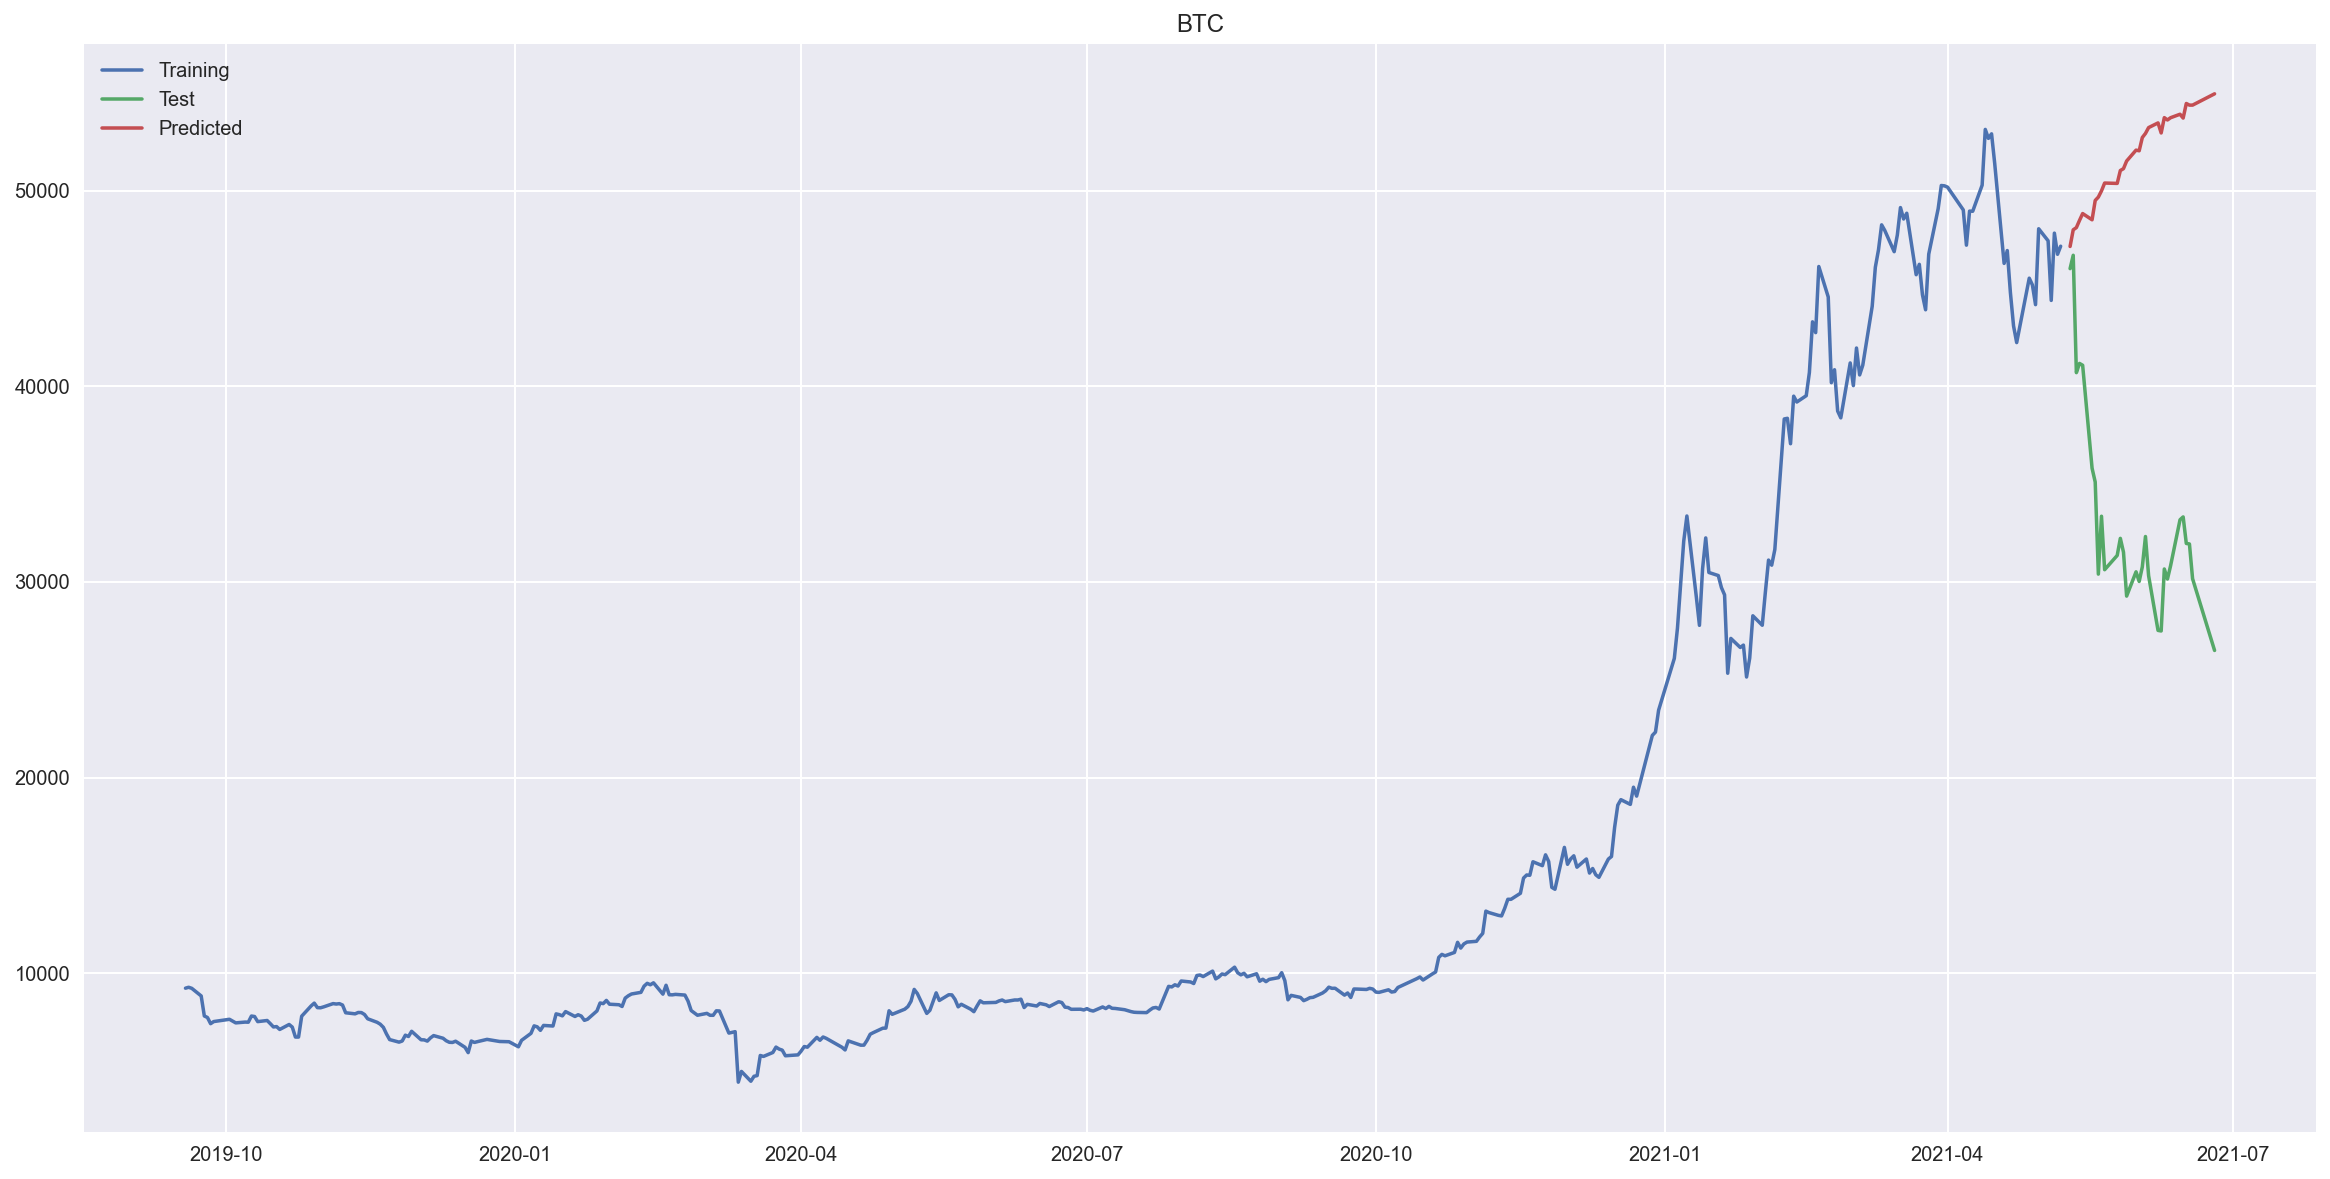

In [31]:
prediction = pd.DataFrame(arima_model.predict(n_periods = len(test)), index = test.index)
prediction.columns = ['Predicted_BTC']

plt.figure(figsize=(20,10))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction,label="Predicted")
plt.title(label ="BTC")
plt.legend(loc = 'best')
plt.show()

In [32]:
test['Predicted_BTC'] = prediction
r2_score_3 = r2_score(test['BTC'], test['Predicted_BTC'])
print(r2_score_3)
math.sqrt(mean_squared_error(test['BTC'],test['Predicted_BTC']))

-14.61899841441971


19765.086640199384

In [33]:
prediction_accuracy = [r2_score_1, r2_score_2, r2_score_3]

In [34]:
prediction_accuracy

[-2.5909949398613574, 0.5725038156579396, -14.61899841441971]

# 2. Stock Market Prediction And Forecasting using Stacked LSTM

The original Long Short-term memory (LSTM) model is comprised of a single hidden LSTM layer followed by a standard feedforward output layer. It is often used to capture temporal dependency patterns.

The Stacked LSTM is an extension to this model that has multiple hidden LSTM layers where each layer contains multiple memory cells. By stacking multi-layer LSTM networkss, it can capture even more complex patterns. <br />
---Xiao, F. (2020). Time Series Forecasting with Stacked Long Short-Term Memory Networks. arXiv preprint arXiv:2011.00697.

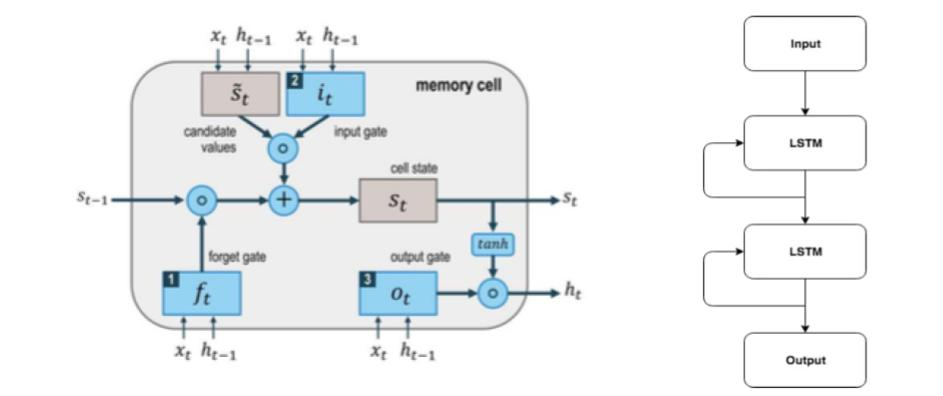

In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [33]:
# LSTM are sensitive to the scale of the data. so we apply MinMax scaler

In [34]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))

scaled_IUS4_DE=scaler.fit_transform(np.array(data['IUS4_DE']).reshape(-1,1))
scaled_DJSC_MI=scaler.fit_transform(np.array(data['DJSC_MI']).reshape(-1,1))
scaled_BTC=scaler.fit_transform(np.array(data['BTC']).reshape(-1,1))

#scaled_IUS4_DE=scaler.fit_transform(np.array(IUS4_DE).reshape(-1,1))
#scaled_DJSC_MI=scaler.fit_transform(np.array(DJSC_MI).reshape(-1,1))
#scaled_BTC=scaler.fit_transform(np.array(BTC).reshape(-1,1))

In [35]:
##splitting dataset into train and test split
def train_test_split_portion(data, train_portion):
    training_size =int(len(data) * train_portion)
    test_size =len(data)-training_size
    train_data,test_data = data[0:training_size,:], data[training_size:len(data),:1]
    return train_data, test_data

In [36]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [37]:
### Plotting 
def Ploting_Stacked_LSTMprediction (original_data, scaled_data, train_predict, test_predict, look_back):
    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(scaled_data)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

    # shift test predictions for plotting
    testPredictPlot = np.empty_like(scaled_data)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(train_predict)+(look_back*2)+1:len(scaled_data)-1, :] = test_predict
    
    trainPredictPlot = pd.DataFrame(trainPredictPlot, index = original_data.index)
    testPredictPlot = pd.DataFrame(testPredictPlot, index = original_data.index)
    real = pd.DataFrame(scaler.inverse_transform(scaled_data), index = original_data.index)
    # plot baseline and predictions

    plt.figure(figsize=(18,10))
    plt.plot(real)
    plt.plot(trainPredictPlot, label="Train Predict")
    plt.plot(testPredictPlot, label="Test Predict")
    plt.legend(loc = 'best')
    plt.show()

In [38]:
def plot_Stacked_LSTM_prediction_30days (original_data, scaled_data, test_data, look_back):
    x_input=test_data[len(test_data)-(look_back+30):len(test_data)-30].reshape(1,-1)  # leave 130 day left
    temp_input=list(x_input)
    temp_input=temp_input[0].tolist()
    
    lst_output=[]
    n_steps=look_back
    i=0
    while(i<30):
    
        if(len(temp_input)>look_back):
            x_input=np.array(temp_input[1:])
            #print("{} day input {}".format(i,x_input))
            x_input=x_input.reshape(1,-1)
            x_input = x_input.reshape((1, n_steps, 1))

            yhat = model.predict(x_input, verbose=0)
            #print("{} day output {}".format(i,yhat))
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]

            lst_output.extend(yhat.tolist())
            i=i+1
        else:
            x_input = x_input.reshape((1, n_steps,1))
            yhat = model.predict(x_input, verbose=0)
            #print(yhat[0])
            temp_input.extend(yhat[0].tolist())
            #print(len(temp_input))
            lst_output.extend(yhat.tolist())
            i=i+1
    
    df1 = pd.DataFrame(scaler.inverse_transform(scaled_data), index = original_data.index)
    df2 = df1[len(df1)-30:]
    df3 = pd.DataFrame(scaler.inverse_transform(lst_output), index = original_data[len(original_data)-30:].index)
    plt.figure(figsize=(20,10))
    plt.plot(df1[:len(df1)-30])
    plt.plot(df2)
    plt.plot(df3, label = 'Prediction')
    plt.legend(loc = 'best')
    #testscore = math.sqrt(mean_squared_error(df2,df3))
    
    
    #return testscore

### 2.1. For IUS4_DE

In [39]:
train_data,test_data = train_test_split_portion(scaled_IUS4_DE, train_portion=0.8)

In [40]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 50
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [41]:
### Create the Stacked LSTM model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(50,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 50)            20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
5/5 [==============================] - 6s 335ms/step - loss: 0.2261 - val_loss: 0.0029
Epoch 2/100
5/5 [==============================] - 0s 74ms/step - loss: 0.0457 - val_loss: 0.0024
Epoch 3/100
5/5 [==============================] - 0s 65ms/step - loss: 0.0210 - val_loss: 0.0433
Epoch 4/100
5/5 [==============================] - 0s 63ms/step - loss: 0.0228 - val_loss: 0.0057
Epoch 5/100
5/5 [==============================] - 0s 67ms/step - loss: 0.0153 - val_loss: 0.0035
Epoch 6/100
5/5 [==============================] - 0s 69ms/step - loss: 0.0145 - val_loss: 0.0068
Epoch 7/100
5/5 [==============================] - 0s 80ms/step - loss: 0.0132 - val_loss: 0.0130
Epoch 8/100
5/5 [==============================] - 0s 81ms/step - loss: 0.0126 - val_loss: 0.0037
Epoch 9/100
5/5 [==============================] - 0s 84ms/step - loss: 0.0118 - val_loss: 0.0024
Epoch 10/100
5/5 [==============================] - 0s 86ms/step - loss: 0.0112 - val_loss: 0.0061
Epoch 11/100
5/5 [

In [43]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

### Calculate RMSE performance metrics
RMSE_trainscore_1 = math.sqrt(mean_squared_error(y_train,train_predict))
RMSE_testscore_1 = math.sqrt(mean_squared_error(ytest,test_predict))
print("RMSE performance metrics for training data: ", RMSE_trainscore_1)
print("RMSE performance metrics for test data: ", RMSE_testscore_1)

##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

RMSE performance metrics for training data:  0.04988904741140716
RMSE performance metrics for test data:  0.07517047024843758


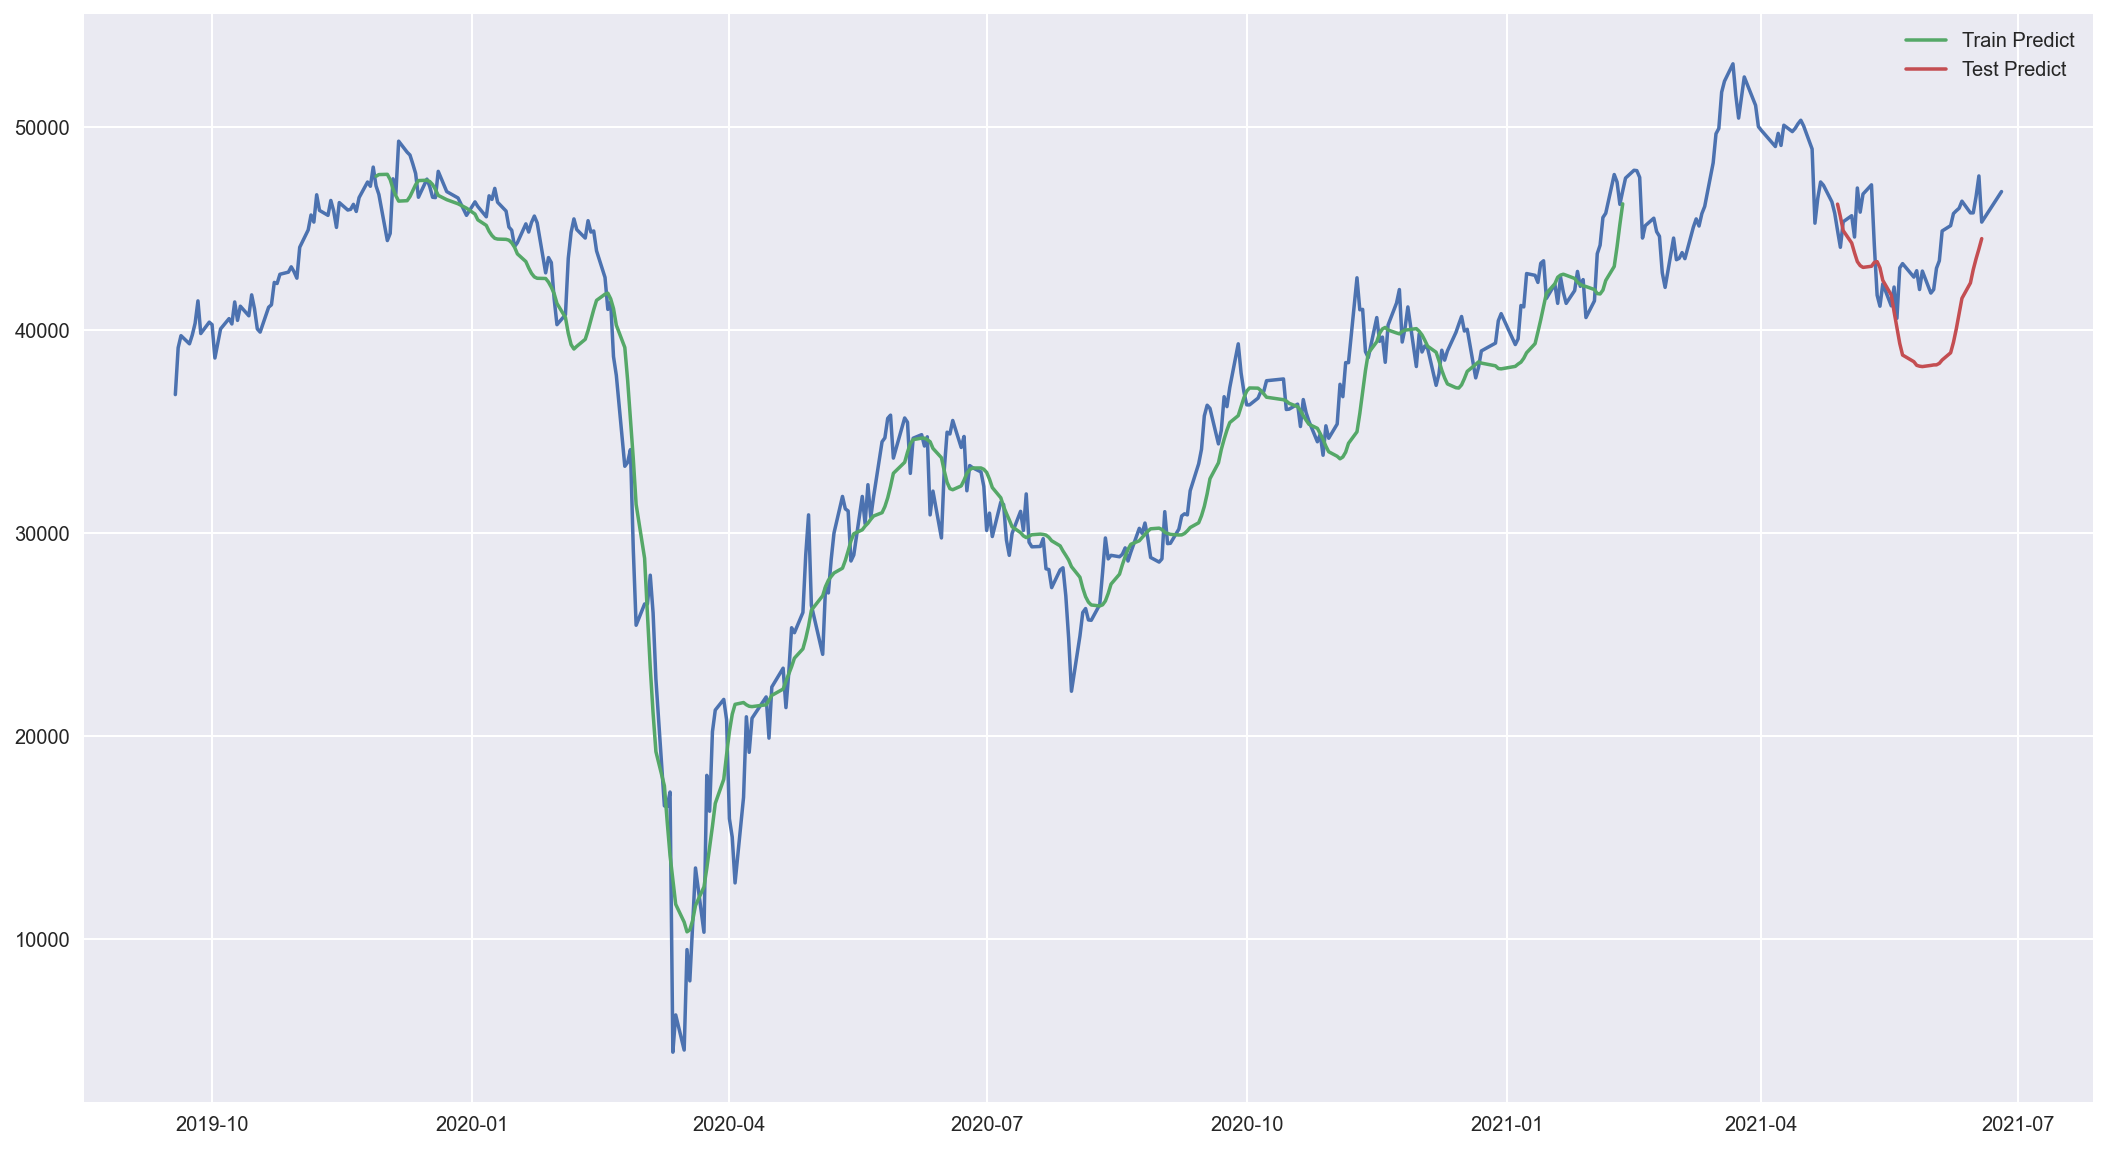

In [44]:
# Ploting Stacked LSTM prediction with original data
Ploting_Stacked_LSTMprediction(data['IUS4_DE'], scaled_IUS4_DE, train_predict, test_predict, look_back=50)

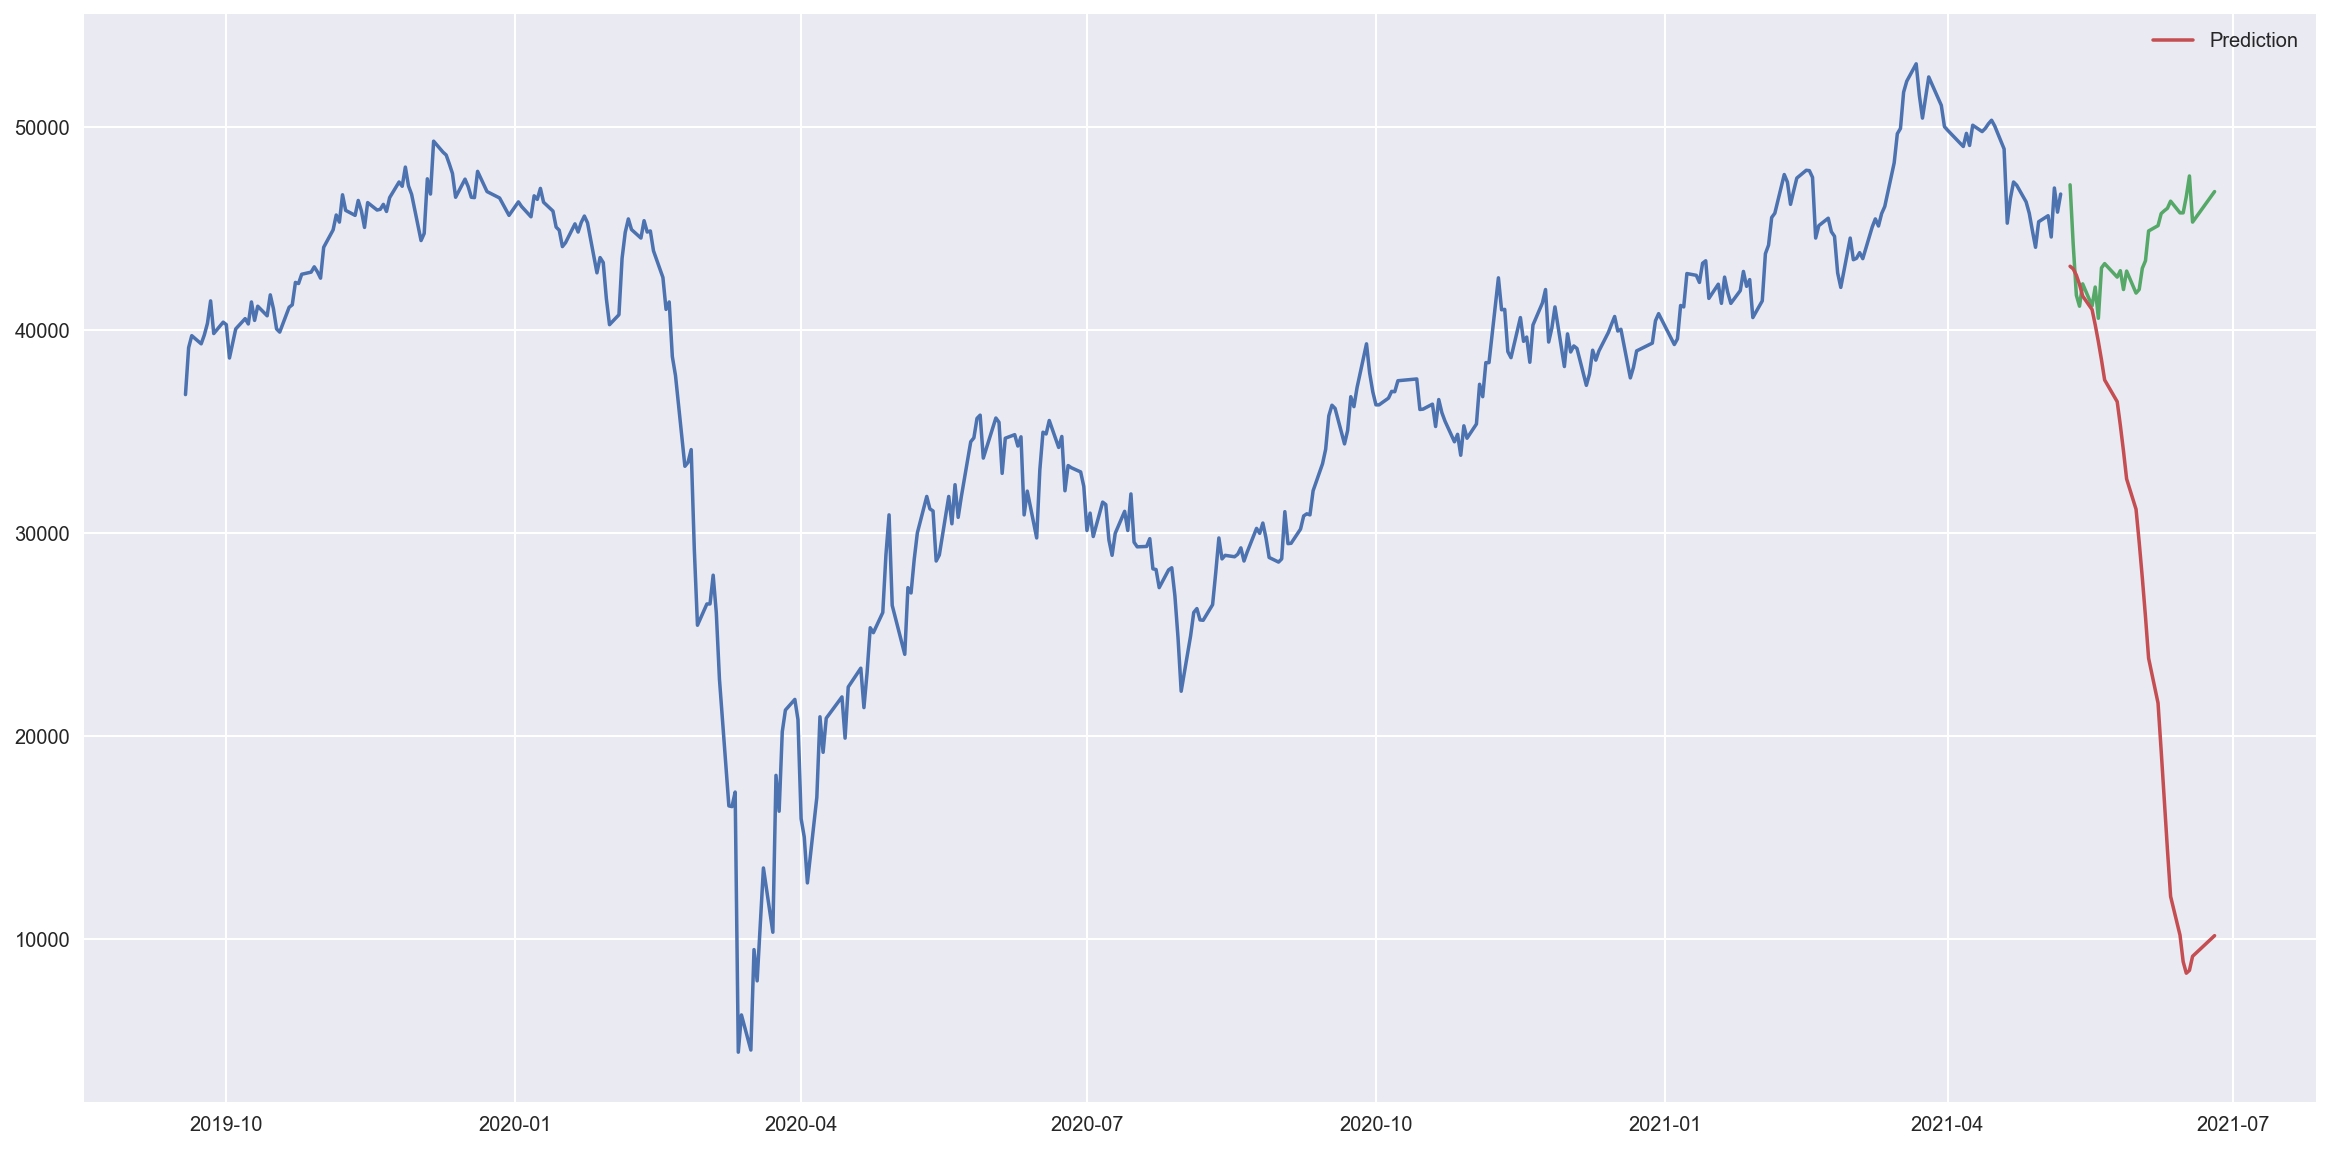

In [45]:
# Using learned model to predict 30 next days
plot_Stacked_LSTM_prediction_30days(data['IUS4_DE'], scaled_IUS4_DE, test_data, look_back=50)

### 2.2. For DJSC_MI

In [46]:
train_data,test_data = train_test_split_portion(scaled_DJSC_MI, train_portion=0.8)

In [47]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 50
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [48]:
### Create the Stacked LSTM model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(50,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 50, 50)            20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [49]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
5/5 [==============================] - 7s 356ms/step - loss: 0.1150 - val_loss: 0.0198
Epoch 2/100
5/5 [==============================] - 0s 73ms/step - loss: 0.0298 - val_loss: 0.0187
Epoch 3/100
5/5 [==============================] - 0s 69ms/step - loss: 0.0136 - val_loss: 0.1133
Epoch 4/100
5/5 [==============================] - 0s 68ms/step - loss: 0.0167 - val_loss: 0.0523
Epoch 5/100
5/5 [==============================] - 0s 70ms/step - loss: 0.0099 - val_loss: 0.0114
Epoch 6/100
5/5 [==============================] - 0s 79ms/step - loss: 0.0114 - val_loss: 0.0321
Epoch 7/100
5/5 [==============================] - 0s 80ms/step - loss: 0.0096 - val_loss: 0.0534
Epoch 8/100
5/5 [==============================] - 0s 85ms/step - loss: 0.0093 - val_loss: 0.0267
Epoch 9/100
5/5 [==============================] - 0s 86ms/step - loss: 0.0083 - val_loss: 0.0168
Epoch 10/100
5/5 [==============================] - 0s 89ms/step - loss: 0.0081 - val_loss: 0.0229
Epoch 11/100
5/5 [

In [50]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

### Calculate RMSE performance metrics
RMSE_trainscore_2 = math.sqrt(mean_squared_error(y_train,train_predict))
RMSE_testscore_2 = math.sqrt(mean_squared_error(ytest,test_predict))
print("RMSE performance metrics for training data: ", RMSE_trainscore_1)
print("RMSE performance metrics for test data: ", RMSE_testscore_1)

##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

RMSE performance metrics for training data:  0.04988904741140716
RMSE performance metrics for test data:  0.07517047024843758


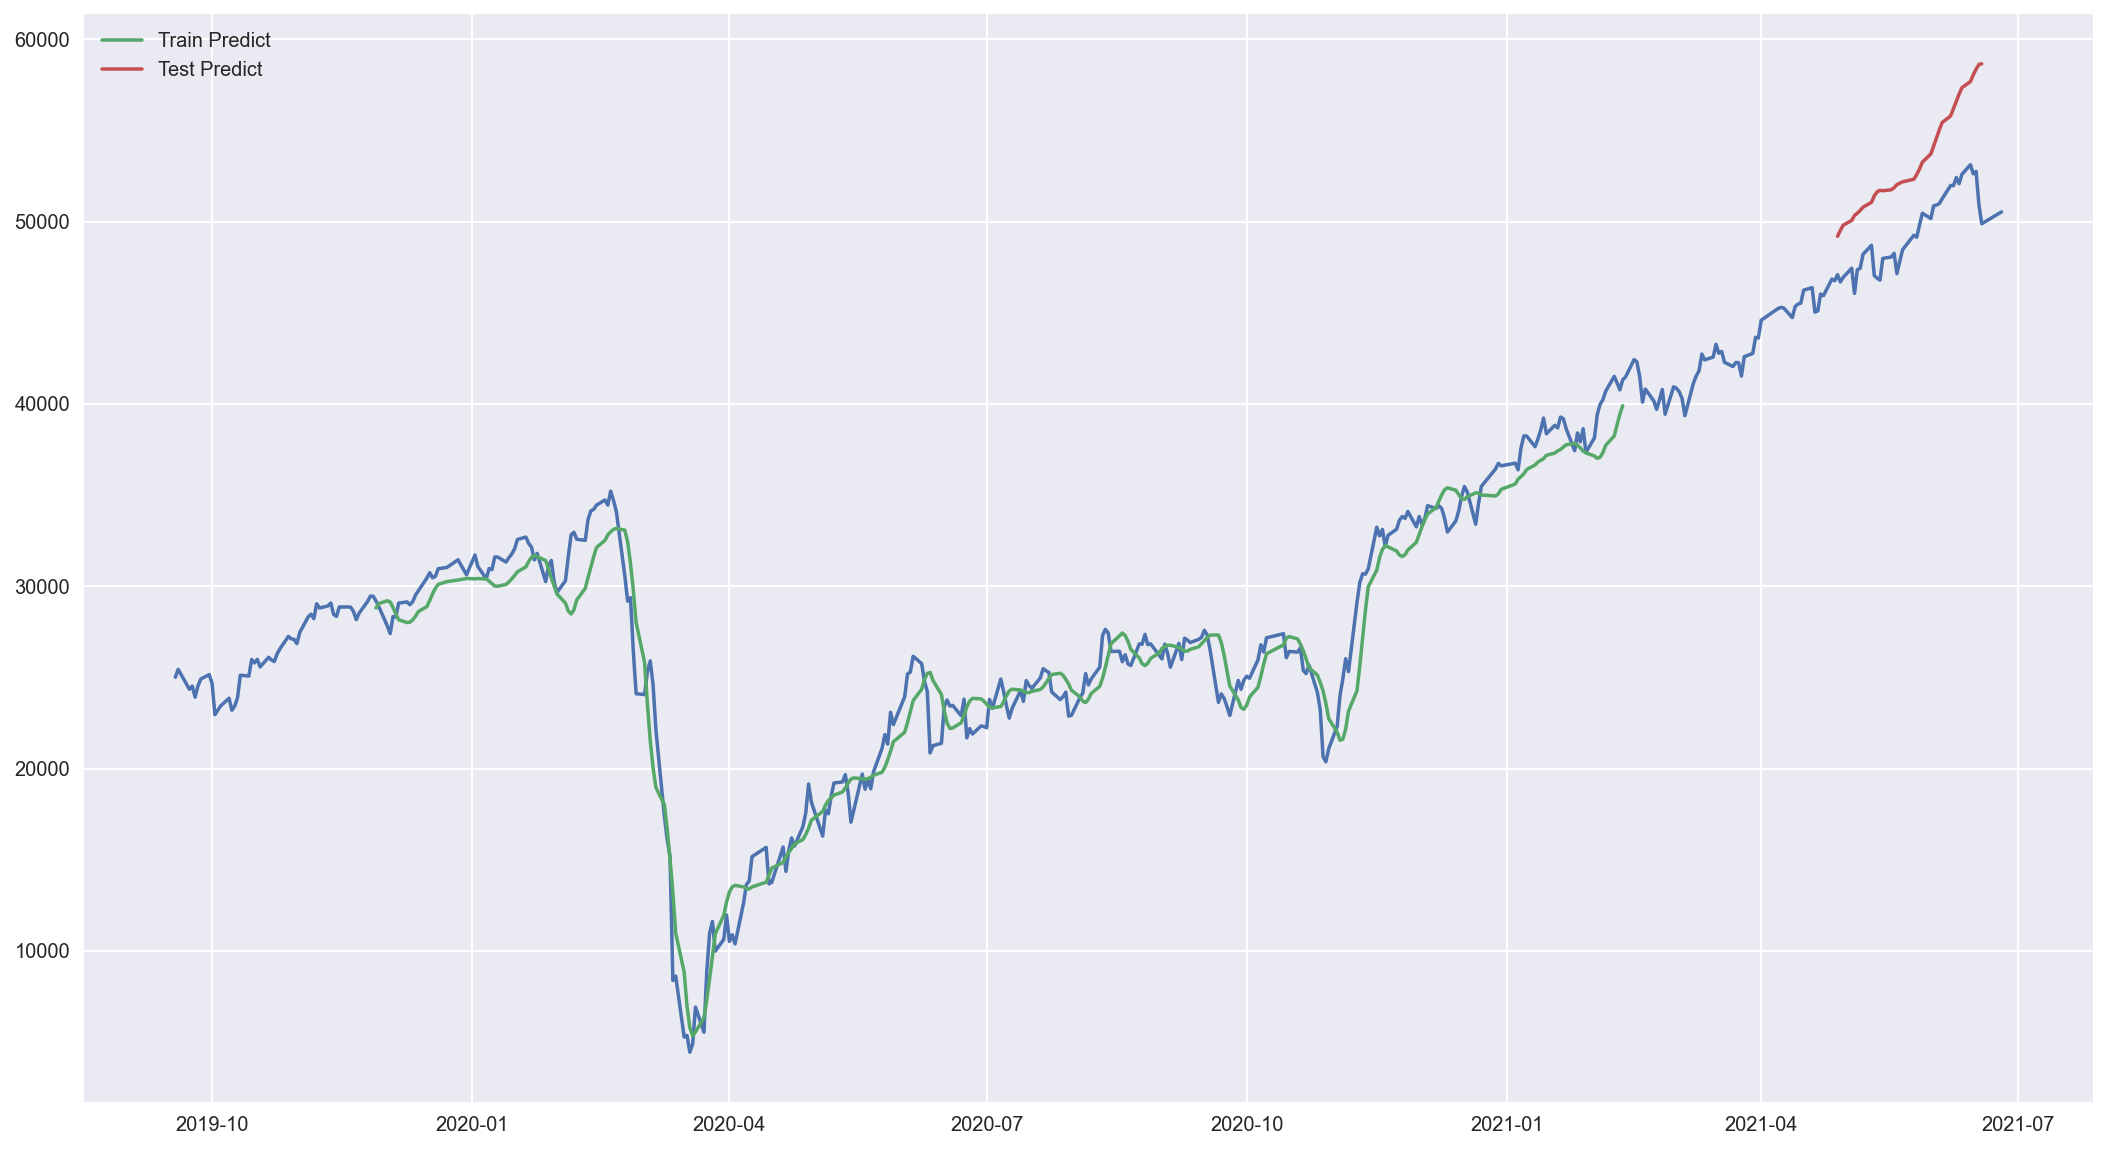

In [51]:
# Ploting Stacked LSTM prediction with original data
Ploting_Stacked_LSTMprediction(data['DJSC_MI'], scaled_DJSC_MI, train_predict, test_predict, look_back=50)

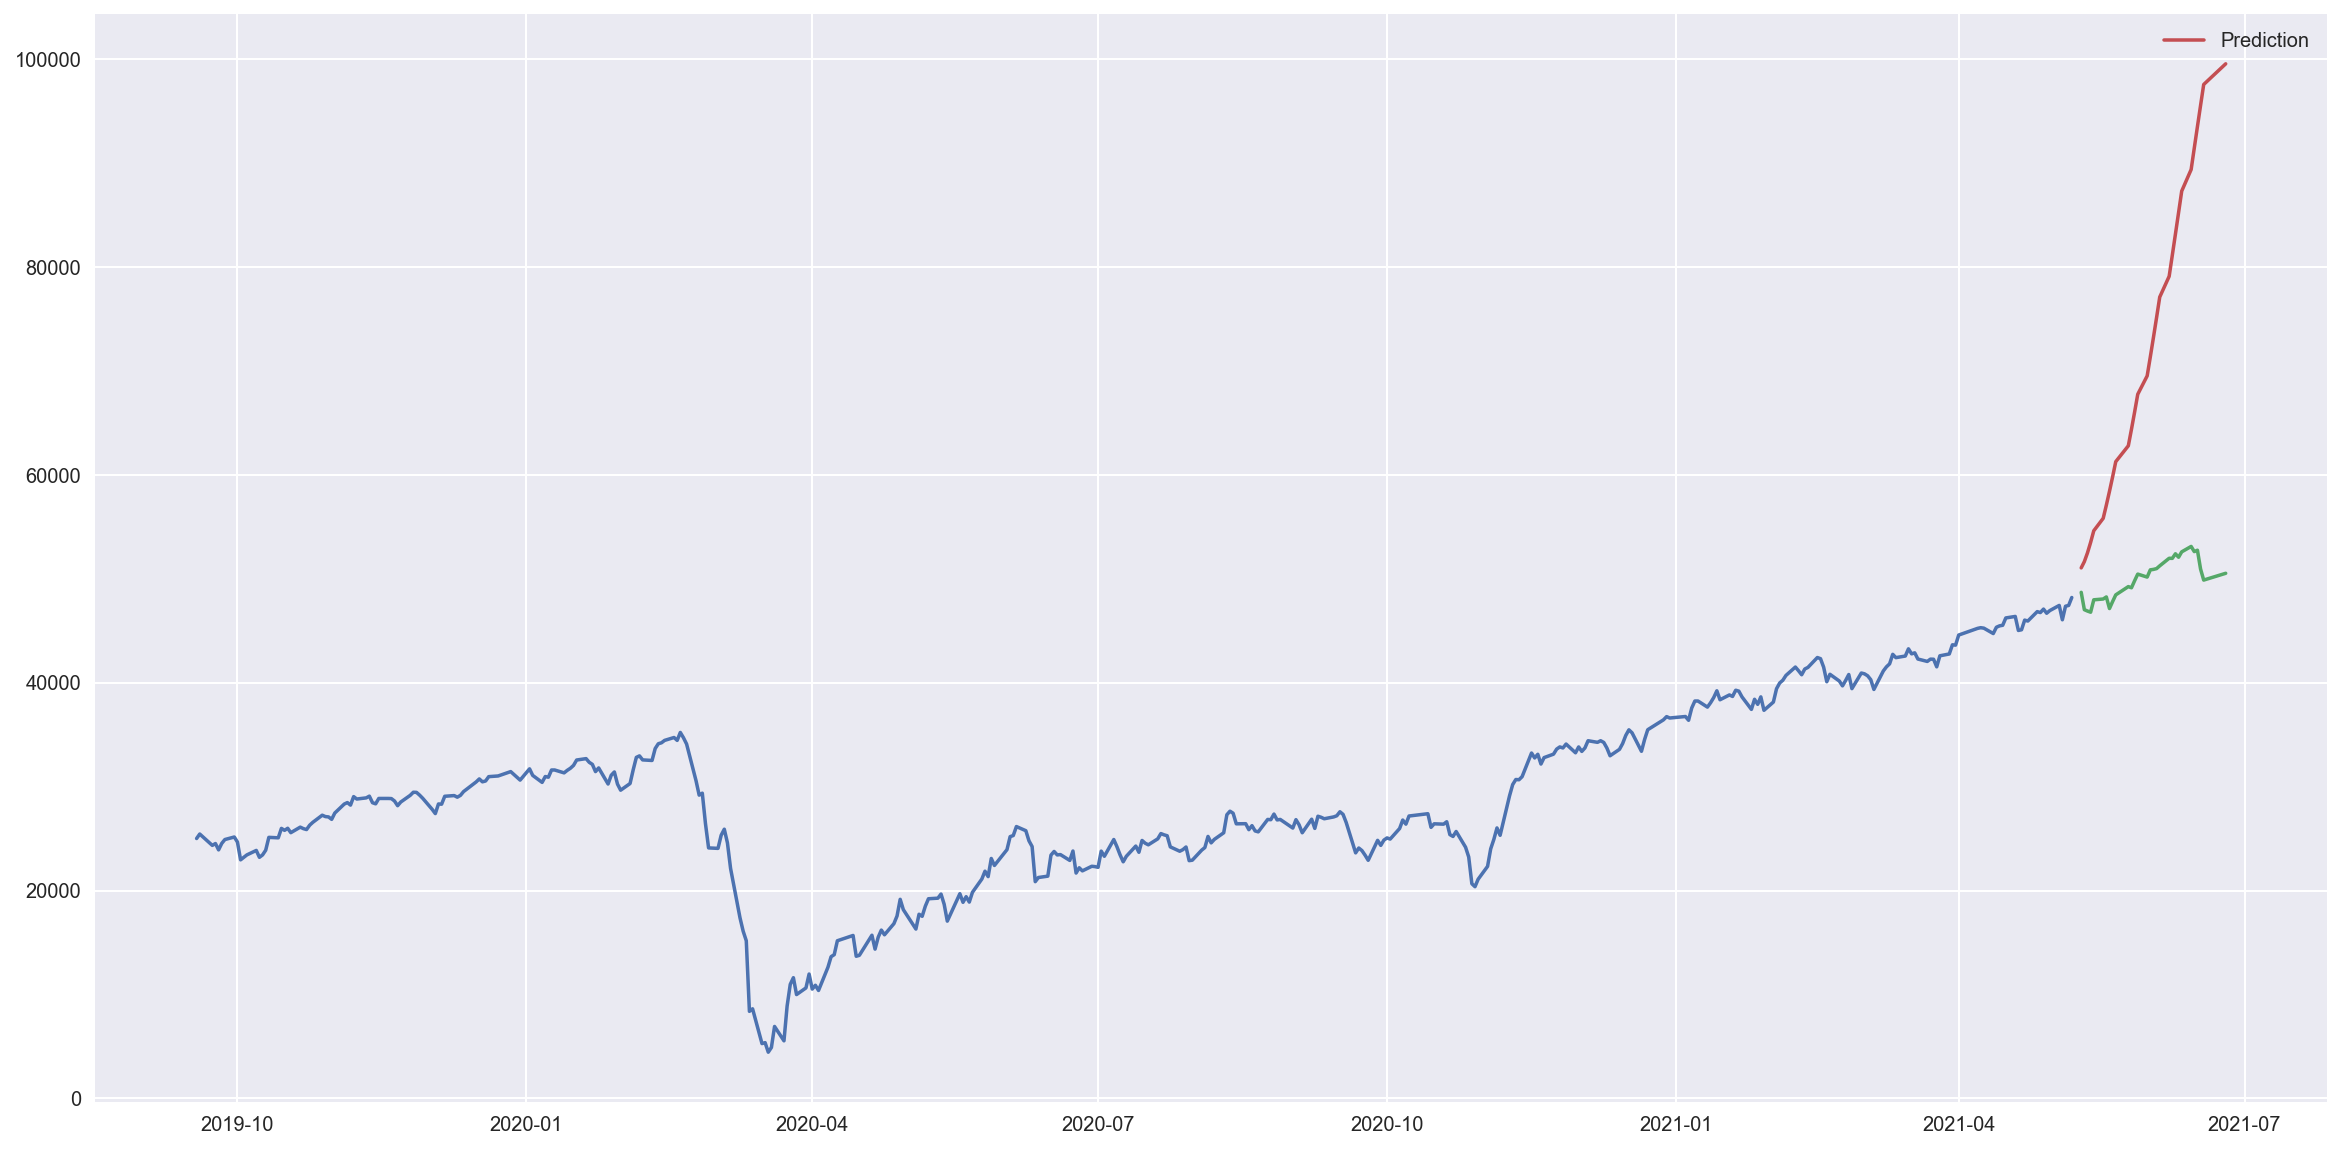

In [52]:
# Using learned model to predict 30 next days
plot_Stacked_LSTM_prediction_30days(data['DJSC_MI'], scaled_DJSC_MI, test_data, look_back=50)

### 2.3. For Bitcoin

In [53]:
train_data,test_data = train_test_split_portion(scaled_BTC, train_portion=0.8)

In [54]:
# reshape : reduce timestep for Bitcoin to 50
time_step = 50
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [55]:
### Create the Stacked LSTM model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(50,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
lstm_7 (LSTM)                (None, 50, 50)            20200     
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [56]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
5/5 [==============================] - 5s 267ms/step - loss: 0.0232 - val_loss: 0.0118
Epoch 2/100
5/5 [==============================] - 0s 62ms/step - loss: 0.0100 - val_loss: 0.0110
Epoch 3/100
5/5 [==============================] - 0s 59ms/step - loss: 0.0056 - val_loss: 0.0103
Epoch 4/100
5/5 [==============================] - 0s 62ms/step - loss: 0.0040 - val_loss: 0.3059
Epoch 5/100
5/5 [==============================] - 0s 60ms/step - loss: 0.0035 - val_loss: 0.1634
Epoch 6/100
5/5 [==============================] - 0s 60ms/step - loss: 0.0031 - val_loss: 0.0608
Epoch 7/100
5/5 [==============================] - 0s 59ms/step - loss: 0.0022 - val_loss: 0.1380
Epoch 8/100
5/5 [==============================] - 0s 57ms/step - loss: 0.0027 - val_loss: 0.1008
Epoch 9/100
5/5 [==============================] - 0s 59ms/step - loss: 0.0023 - val_loss: 0.0451
Epoch 10/100
5/5 [==============================] - 0s 60ms/step - loss: 0.0021 - val_loss: 0.0975
Epoch 11/100
5/5 [

In [57]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

### Calculate RMSE performance metrics
RMSE_trainscore_3 = math.sqrt(mean_squared_error(y_train,train_predict))
RMSE_testscore_3 = math.sqrt(mean_squared_error(ytest,test_predict))
print("RMSE performance metrics for training data: ", RMSE_trainscore_1)
print("RMSE performance metrics for test data: ", RMSE_testscore_1)

##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

RMSE performance metrics for training data:  0.04988904741140716
RMSE performance metrics for test data:  0.07517047024843758


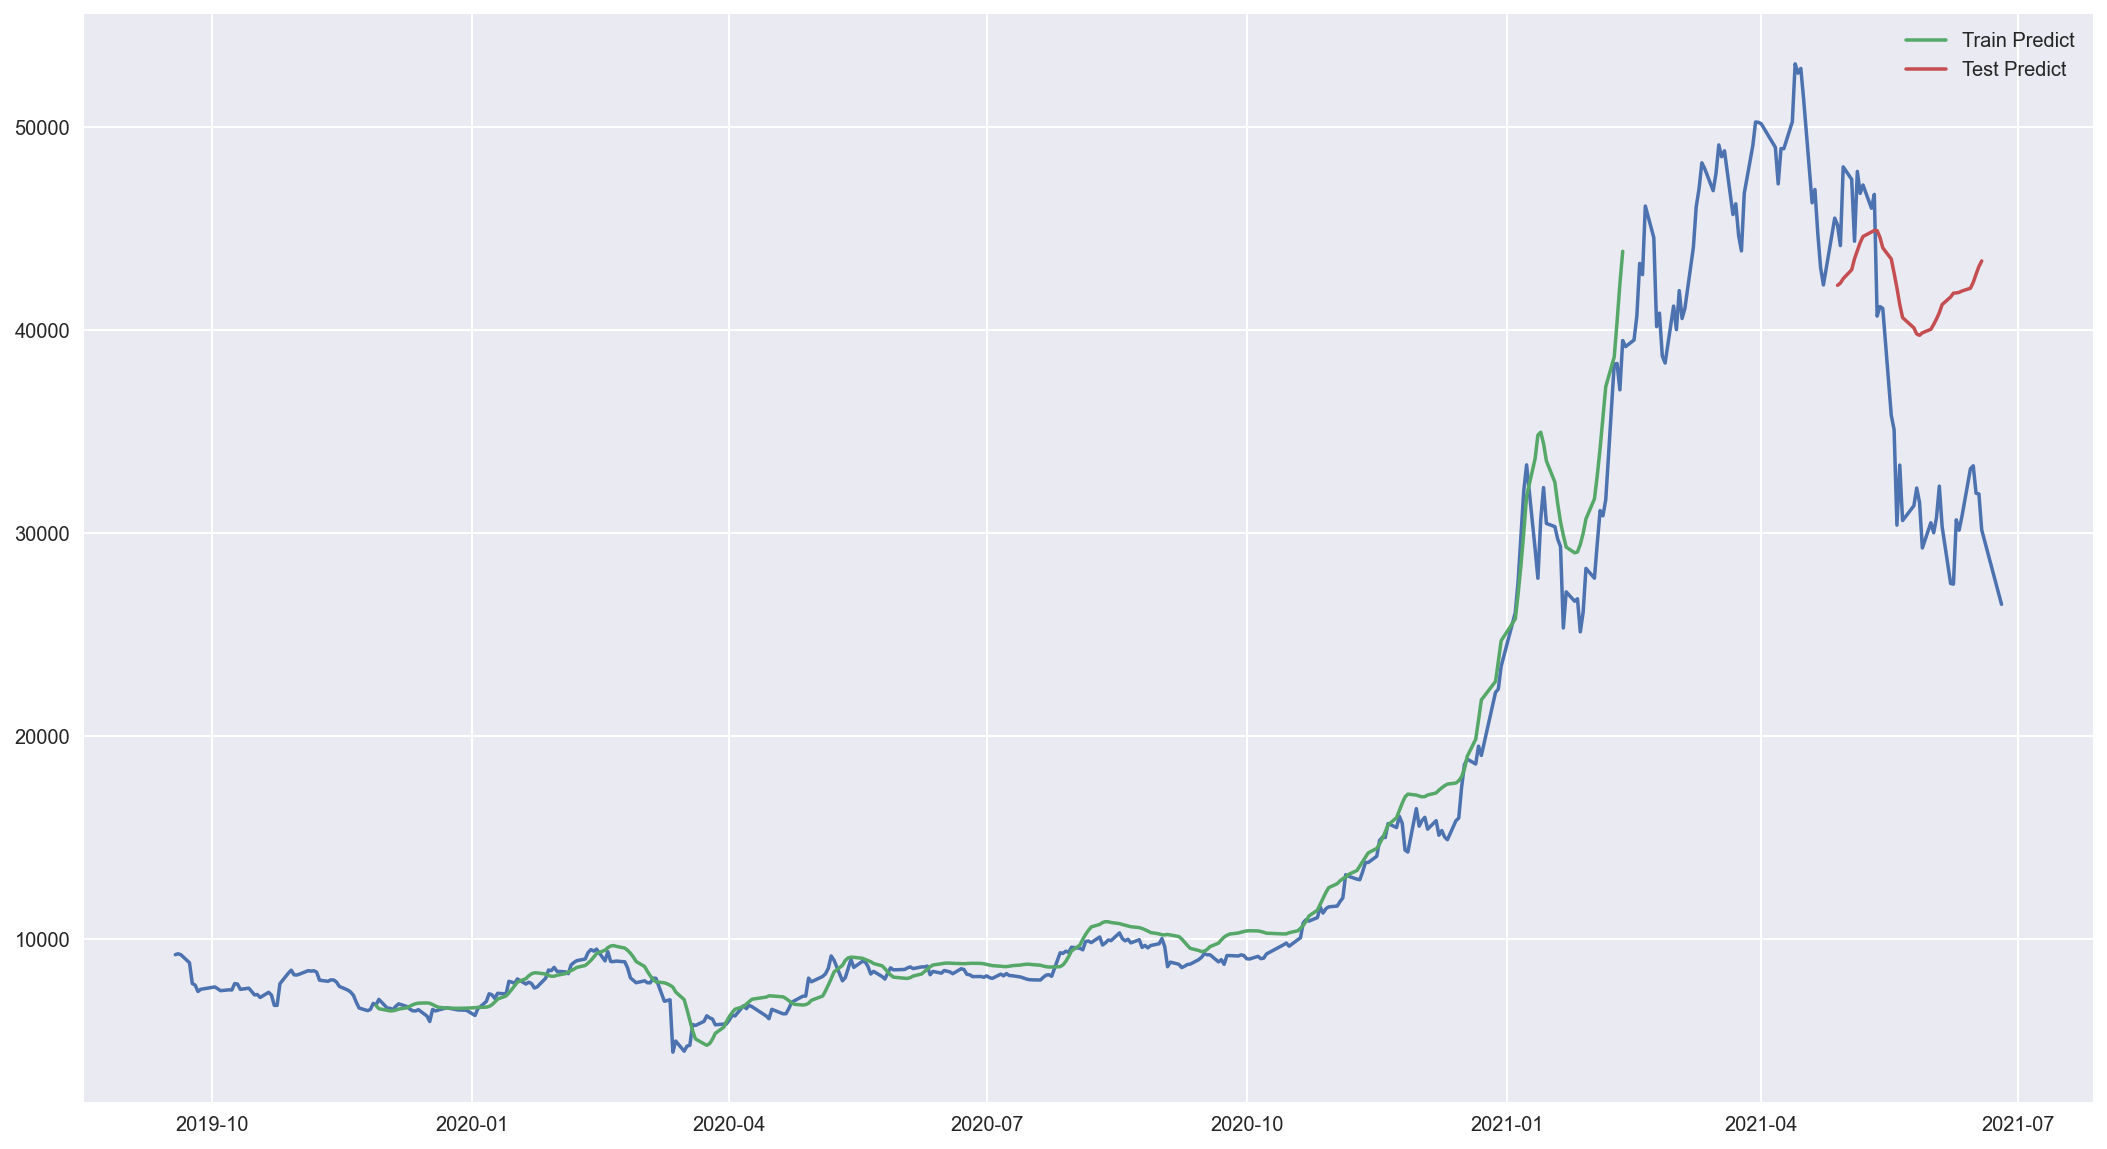

In [58]:
# Ploting Stacked LSTM prediction with original data
Ploting_Stacked_LSTMprediction(data['BTC'], scaled_BTC, train_predict, test_predict, look_back=50)

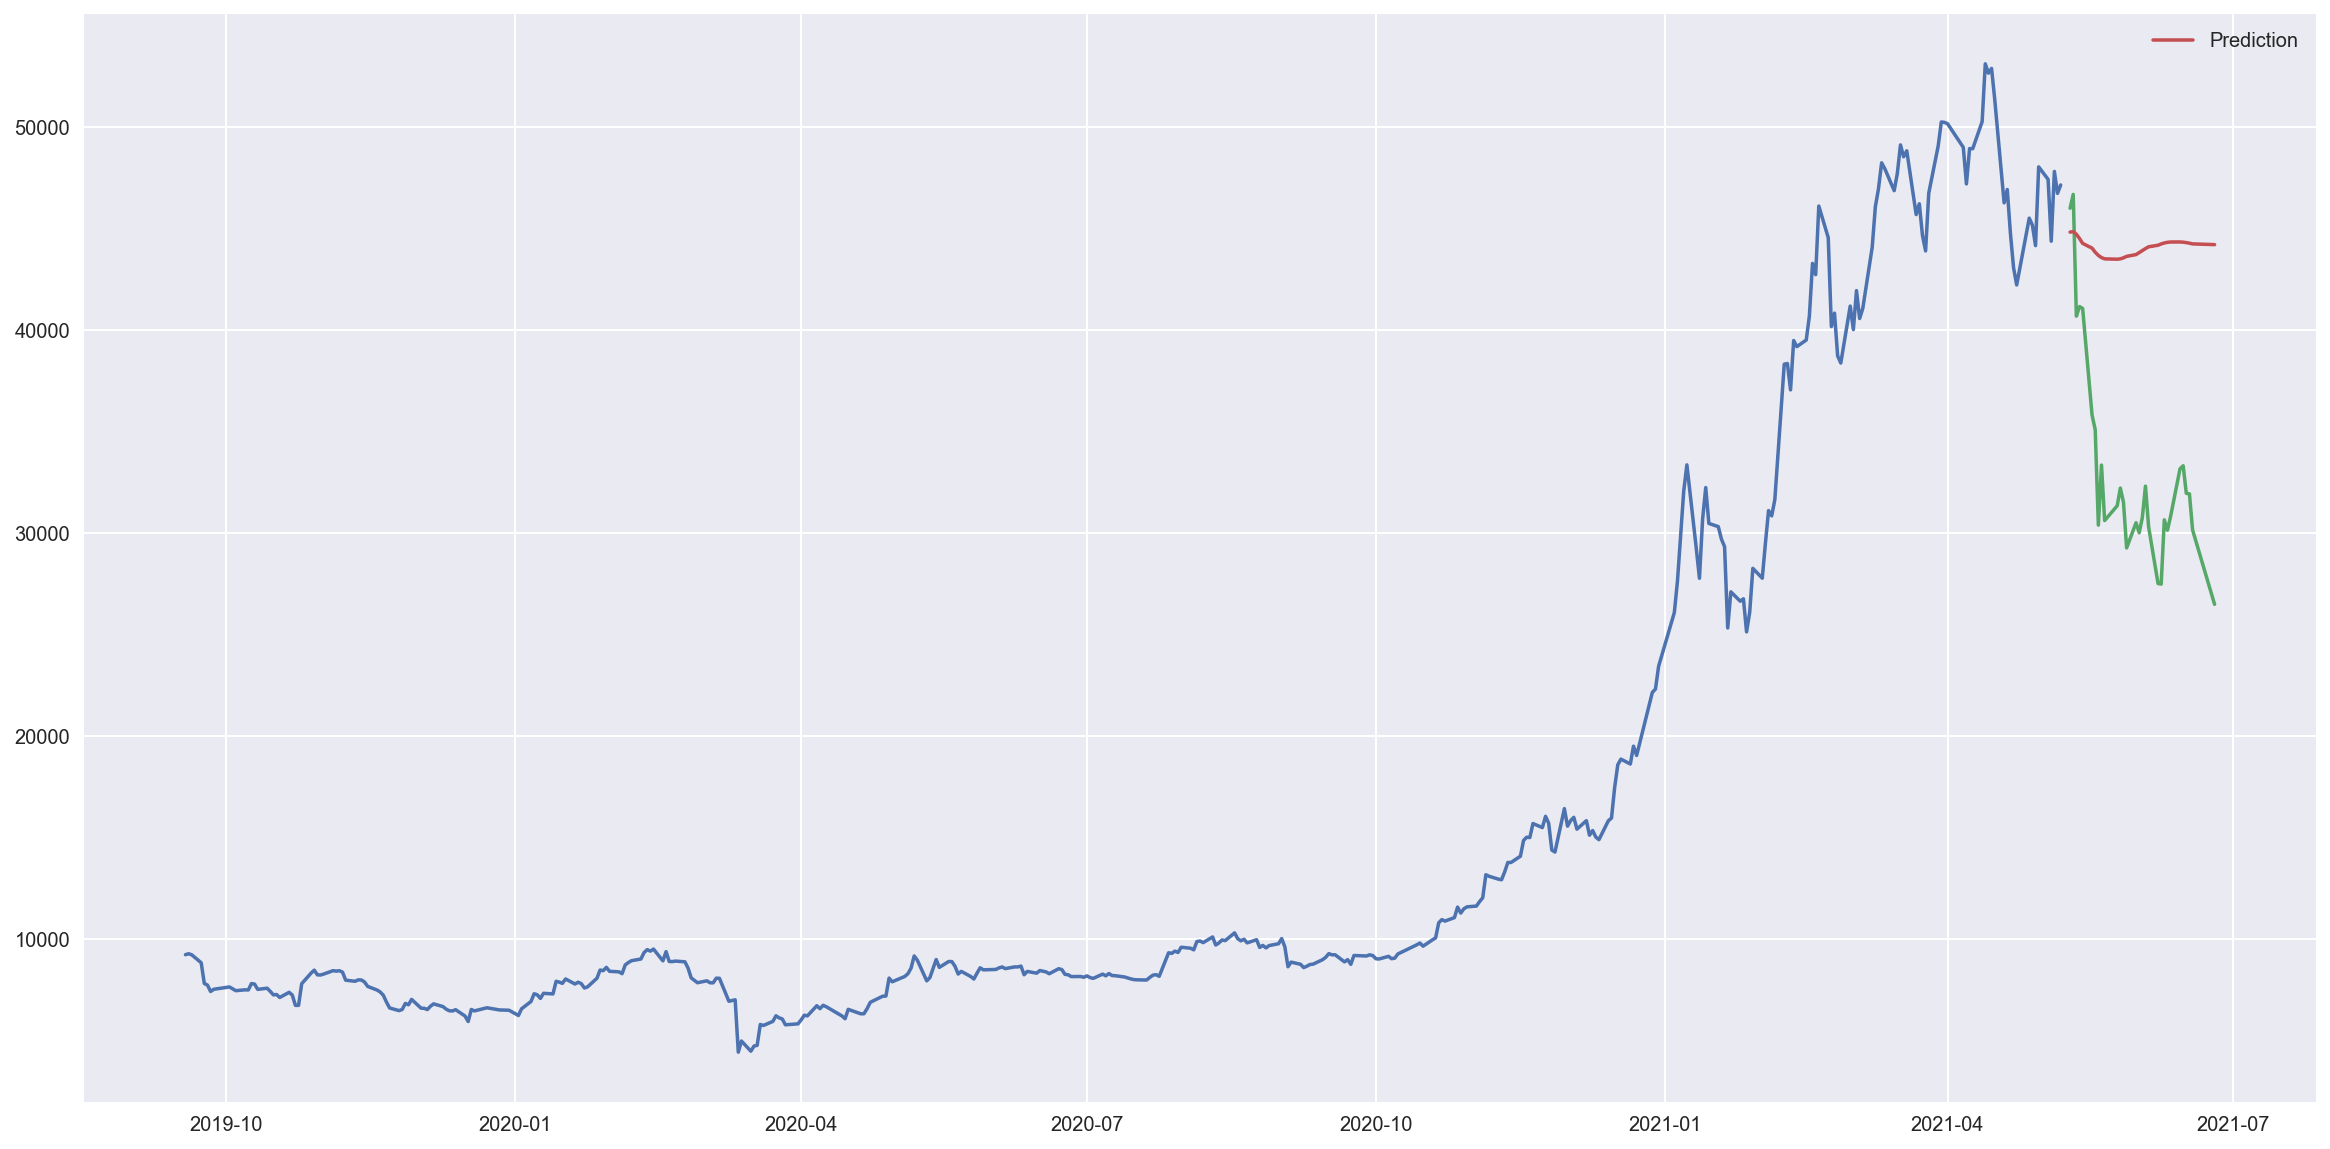

In [59]:
# Using learned model to predict 30 next days
plot_Stacked_LSTM_prediction_30days(data['BTC'], scaled_BTC, test_data, look_back=50)

In [60]:
prediction_accuracy_RMSE =  ([RMSE_trainscore_1, RMSE_trainscore_2, RMSE_trainscore_3], 
                             [RMSE_testscore_1, RMSE_testscore_2, RMSE_testscore_3])

In [64]:
prediction_accuracy_RMSE

([0.04988904741140716, 0.03470217848179069, 0.02748730126889506],
 [0.07517047024843758, 0.08699336718392578, 0.17606869882978893])